# **Artificial Neural Networks and Deep Learning**

---

## **Lecture 4: Timeseries Classification**

<img src="https://drive.google.com/uc?export=view&id=1URwMSSlsgI716DsPSQVJXhll3vaPgL7v" width="500"/>

## 🌐 **Google Drive Connection**

In [1]:

from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/[2025-2026]\\ AN2DL/Challenge\\ 1"
%cd $current_dir

Mounted at /gdrive
/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1


## ⚙️ **Libraries Import**

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [3]:
# Set environment variables for Activity Recognition dataset
os.environ["TRAIN_FILE"] = "pirate_pain_train.csv"
os.environ["LABEL_FILE"] = "pirate_pain_train_labels.csv"
os.environ["TEST_FILE"] = "pirate_pain_test.csv"
os.environ["SAMPLE_FILE"] = "sample_submission.csv"

for f in [os.environ["TRAIN_FILE"], os.environ["LABEL_FILE"], os.environ["TEST_FILE"]]:
    assert os.path.exists(f), f"Missing file: {f}"
print("All dataset files found locally.")

All dataset files found locally.


## 🔎 **Exploration and Data Analysis**

In [4]:
# Load the training and labels datasets
X_train = pd.read_csv(os.environ["TRAIN_FILE"])
y_train = pd.read_csv(os.environ["LABEL_FILE"])

X_test_s = pd.read_csv(os.environ["TEST_FILE"])

# Merge features and labels using 'sample_index'
df = X_train.merge(y_train, on="sample_index")
df_test_s = X_test_s
# Remove possible missing values
df.dropna(inplace=True)

# Print dataset shape and show sample
print(f"Training DataFrame shape: {df.shape}")
df.head(10)

Training DataFrame shape: (105760, 41)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5,no_pain
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5,no_pain
7,0,7,2,2,2,2,two,two,two,1.038597,...,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5,no_pain
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5,no_pain
9,0,9,0,2,2,2,two,two,two,1.054999,...,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5,no_pain


In [5]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [6]:
# Seleziona tutte le colonne dei joint
joint_cols = [col for col in df.columns if col.startswith("joint_")]

# Converte in float32
df[joint_cols] = df[joint_cols].astype(np.float32)

# Verifica che tutto sia a posto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

In [7]:
# Seleziona tutte le colonne dei joint
joint_cols = [col for col in df_test_s.columns if col.startswith("joint_")]

# Converte in float32
df_test_s[joint_cols] = df_test_s[joint_cols].astype(np.float32)

# Verifica che tutto sia a posto
df_test_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  int64  
 3   pain_survey_2  211840 non-null  int64  
 4   pain_survey_3  211840 non-null  int64  
 5   pain_survey_4  211840 non-null  int64  
 6   n_legs         211840 non-null  object 
 7   n_hands        211840 non-null  object 
 8   n_eyes         211840 non-null  object 
 9   joint_00       211840 non-null  float32
 10  joint_01       211840 non-null  float32
 11  joint_02       211840 non-null  float32
 12  joint_03       211840 non-null  float32
 13  joint_04       211840 non-null  float32
 14  joint_05       211840 non-null  float32
 15  joint_06       211840 non-null  float32
 16  joint_07       211840 non-null  float32
 17  joint_08       211840 non-nul

In [8]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202049,0.197606,0.295603,0.300786,...,4.974359e-03,5.472111e-03,1.235068e-03,4.063172e-04,3.205551e-03,0.060292,0.079820,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746148e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,2.800090e-06,3.079464e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


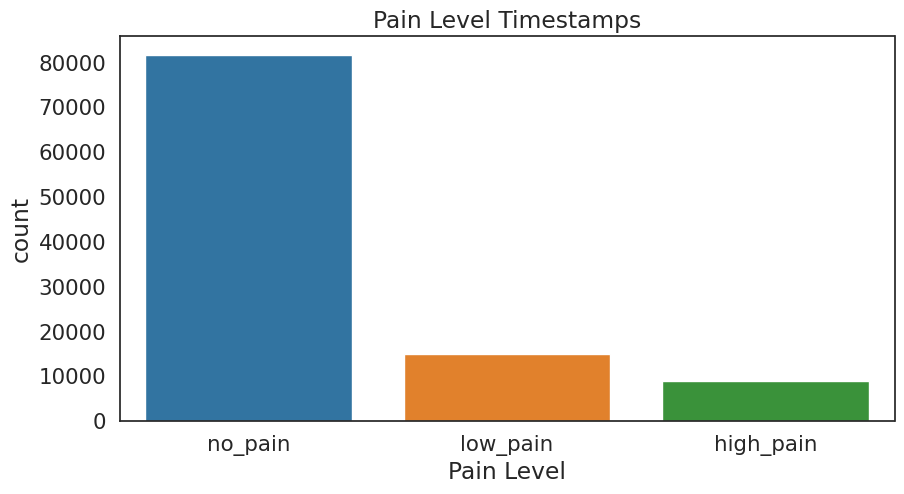

In [9]:
# Visualise the count of timestamps for each pain level
plt.figure(figsize=(10, 5))
sns.countplot(
    x='label',
    data=df,
    order=df['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Level Timestamps')
plt.xlabel('Pain Level')

# Display the plot
plt.show()

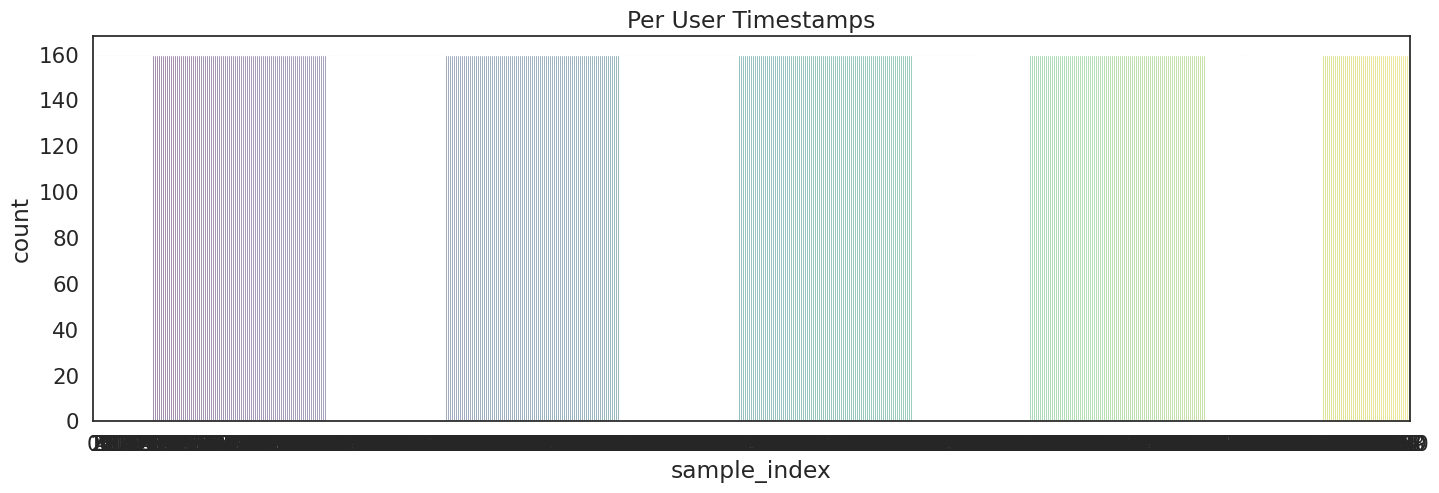

In [10]:
# Count the number of unique users
n_users = len(df['sample_index'].unique())

# Create a custom colour map with distinct colours for each user
colors = plt.cm.viridis(np.linspace(0, 1, n_users))

# Visualise the count of timestamps for each user
plt.figure(figsize=(17, 5))
sns.countplot(
    x='sample_index',
    data=df,
    palette=colors
)

# Set the title of the plot
plt.title('Per User Timestamps')

# Display the plot
plt.show()

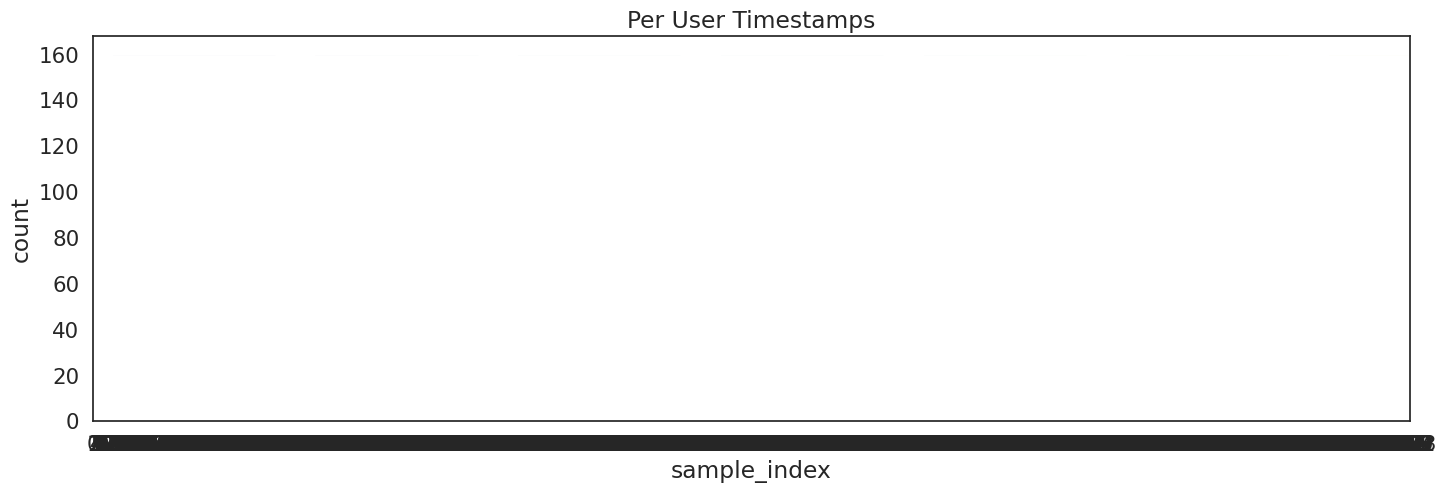

In [11]:
# Count the number of unique users
n_users = len(df_test_s['sample_index'].unique())

# Create a custom colour map with distinct colours for each user
colors = plt.cm.viridis(np.linspace(0, 1, n_users))

# Visualise the count of timestamps for each user
plt.figure(figsize=(17, 5))
sns.countplot(
    x='sample_index',
    data=df_test_s,
    palette=colors
)

# Set the title of the plot
plt.title('Per User Timestamps')

# Display the plot
plt.show()

In [12]:
# Define a function to inspect data for a specific pain_level
def inspect_pain_level(pain_level, df, features=None, n_samples=160):
    """
    Visualizza i segnali temporali dei giunti (o di altre feature)
    per un certo livello di dolore.

    Parameters
    ----------
    pain_level : str | int
        Il livello di dolore da visualizzare (es. 'low_pain' o 1)
    df : DataFrame
        Dataset completo con colonne ['sample_index', 'time', ... , 'pain_level']
    features : list[str] | None
        Quali feature visualizzare; default = prime 3 colonne joint_*
    n_samples : int
        Numero massimo di righe da plottare per non appesantire la figura
    """
    # Seleziona le feature (ad esempio 3 giunti)
    if features is None:
        features = [c for c in df.columns if c.startswith("joint_")][:3]

    # Filtra le righe di quel livello di dolore
    data = df[df["label"] == pain_level][features].head(n_samples)

    # Plot
    ax = data.plot(subplots=True, figsize=(14, 8), title=f"Pain level: {pain_level}")

    for a in ax:
        a.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

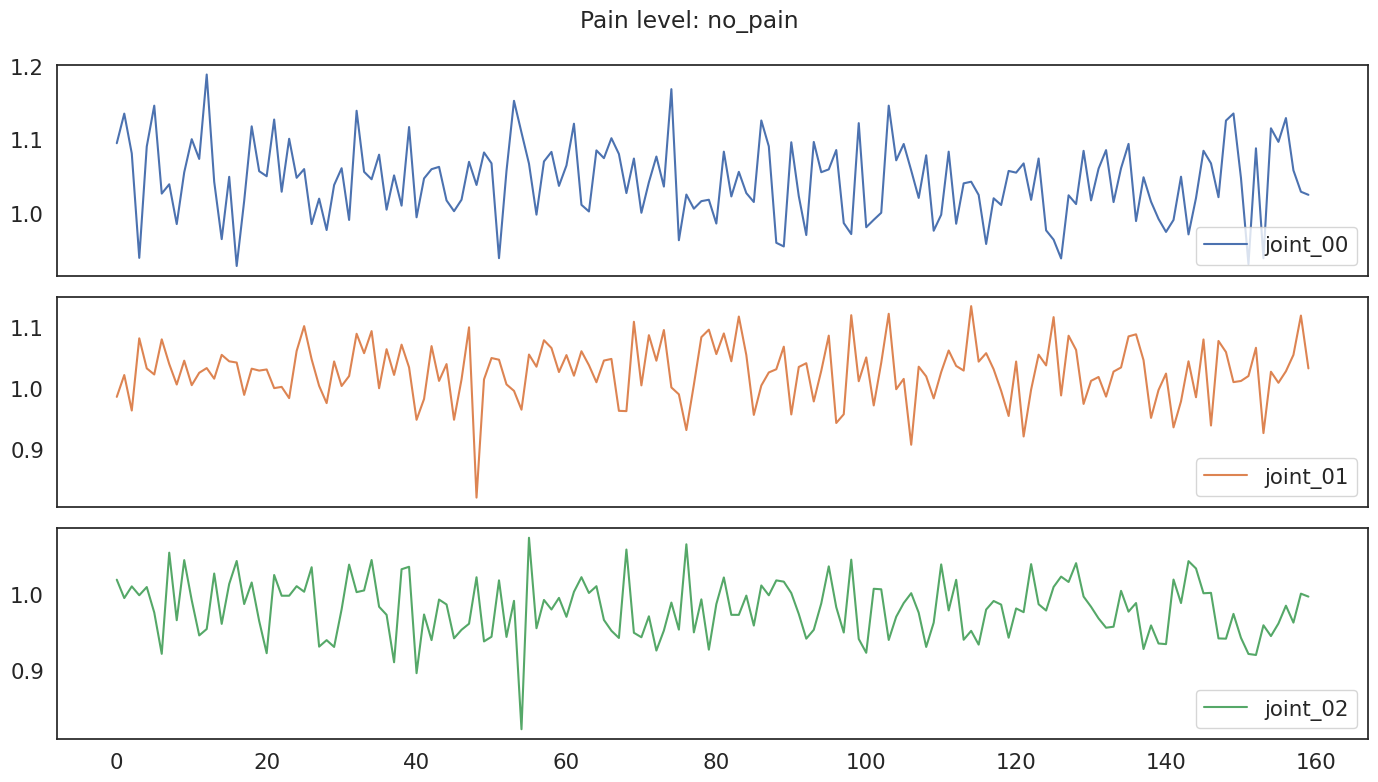

In [13]:
inspect_pain_level("no_pain", df)

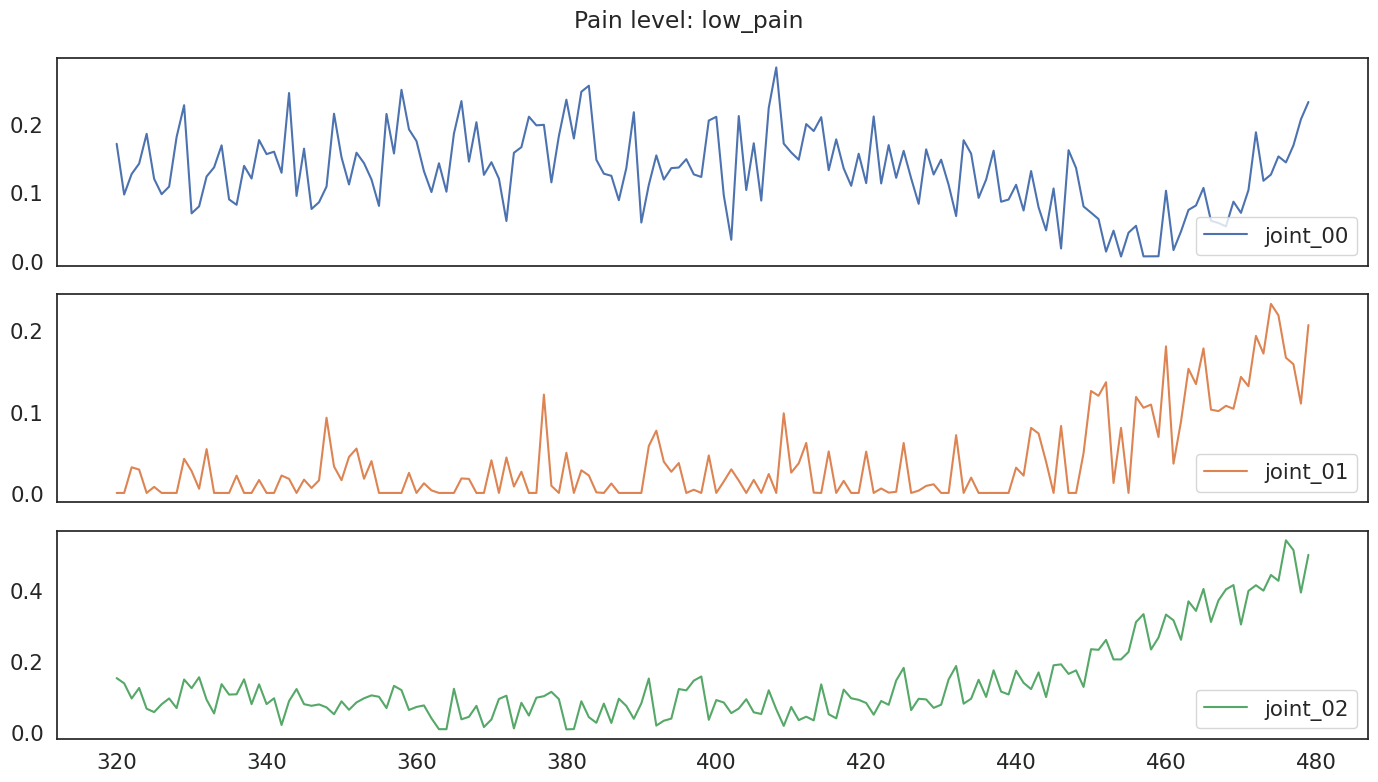

In [14]:
inspect_pain_level("low_pain", df)

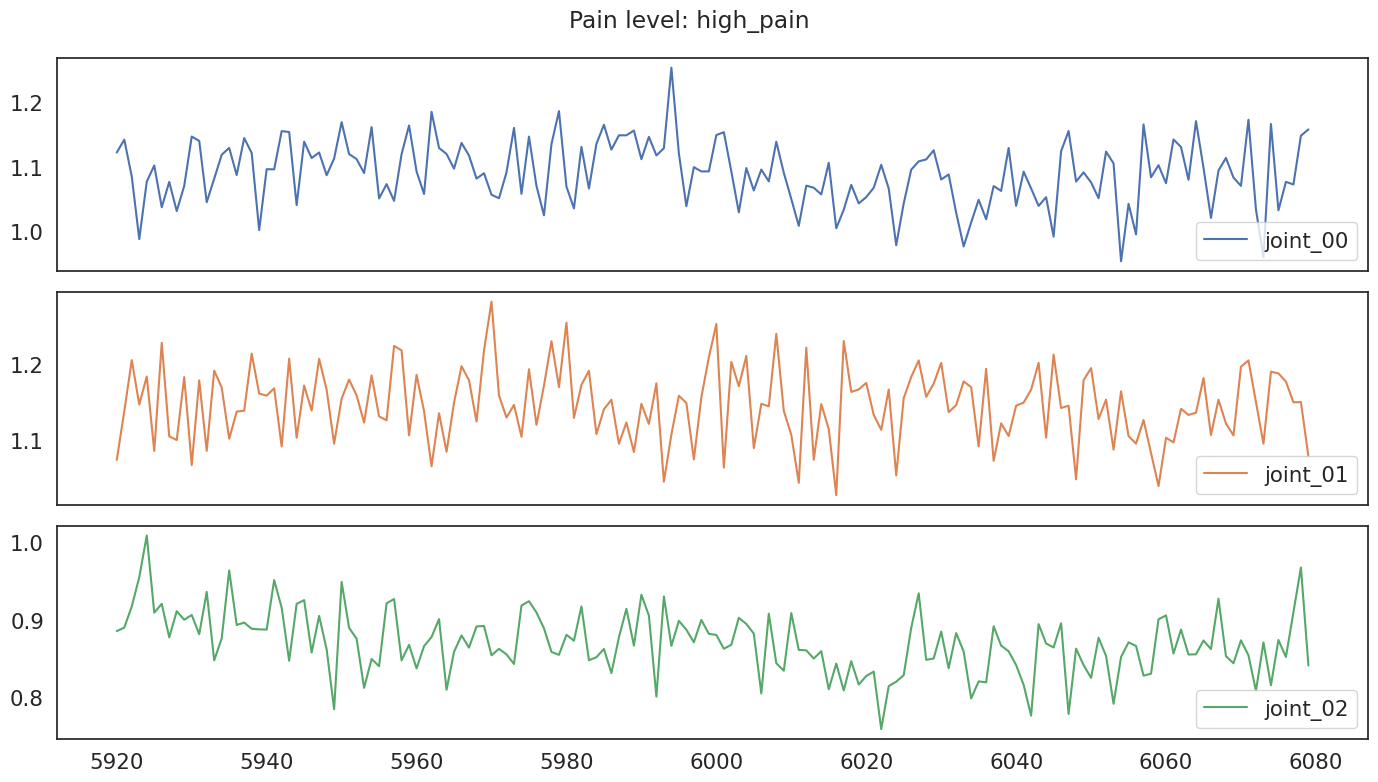

In [15]:
inspect_pain_level("high_pain", df)

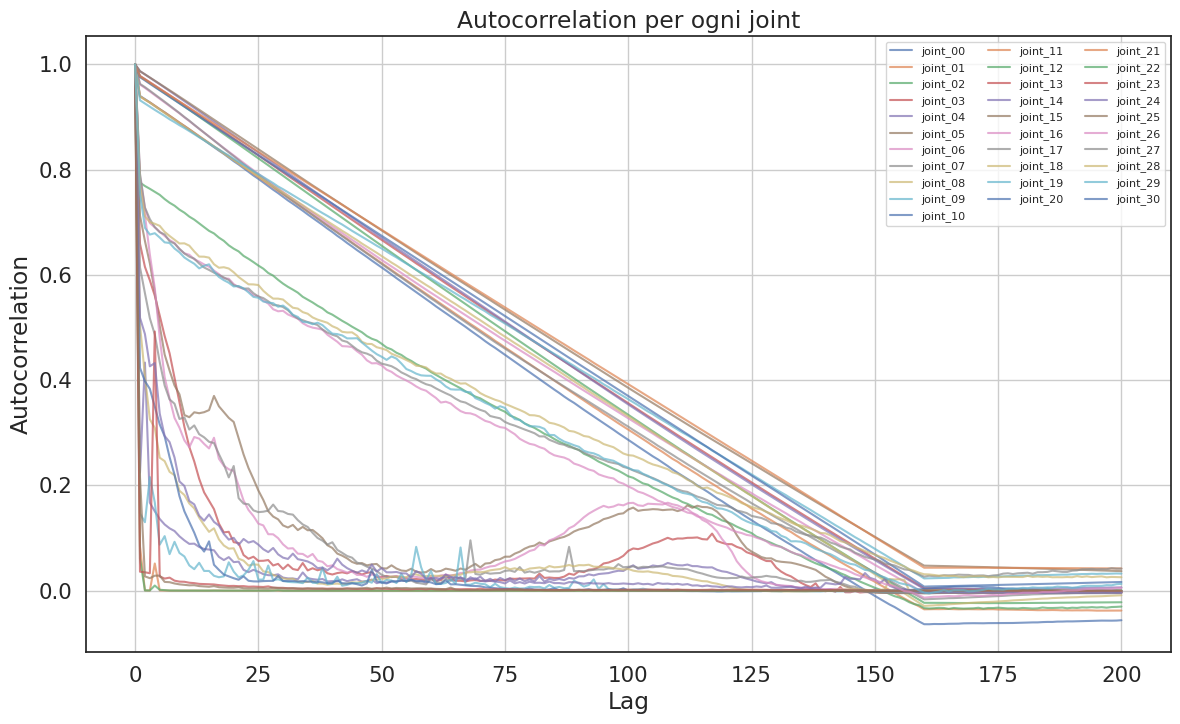

In [16]:
from statsmodels.tsa.stattools import acf
# Seleziona tutte le colonne che iniziano con 'joint_'
joint_cols = [c for c in df.columns if c.startswith("joint_")]

# Imposta la lunghezza massima del lag (puoi variare in base alla finestra che vuoi esplorare)
MAX_LAG = 200

plt.figure(figsize=(14, 8))

# Calcola e traccia l'autocorrelazione per ogni joint
for col in joint_cols:
    acf_values = acf(df[col], nlags=MAX_LAG, fft=True)  # fft=True per velocità
    plt.plot(acf_values, label=col, alpha=0.7)

plt.title("Autocorrelation per ogni joint")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend(ncol=3, fontsize=8)
plt.grid(True)
plt.show()

## 🔄 **Data Preprocessing**

The dataset is composed of 661 different pain_level executions


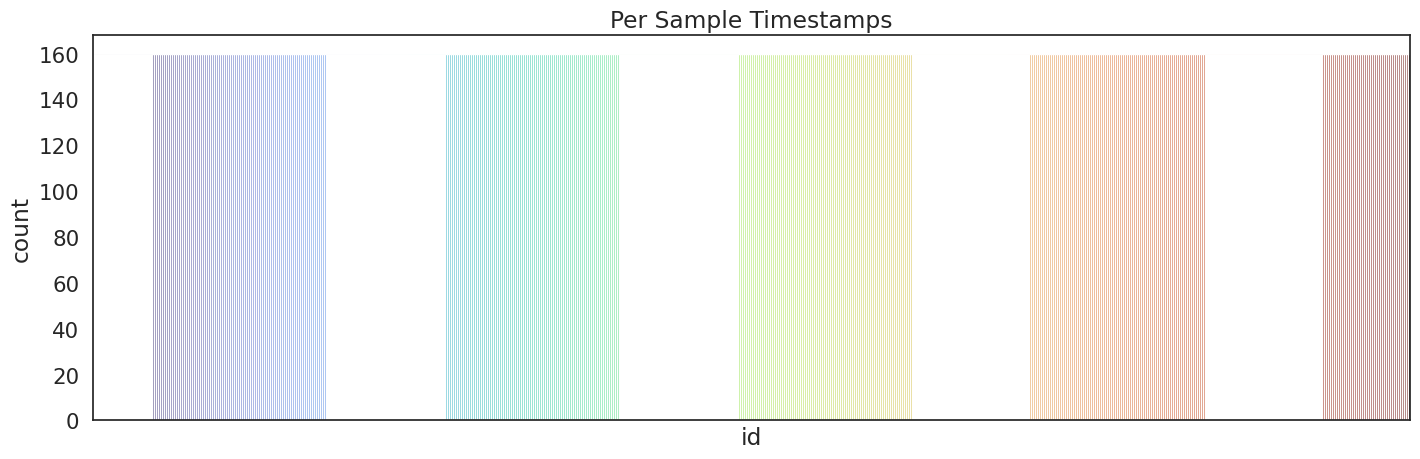

In [17]:
static_cols = ["n_legs", "n_hands", "n_eyes"]

def process_static_cols(dataframe, columns):
    for c in columns:
        s = dataframe[c]

        # Try to interpret as numeric (if already 1/2, it remains so)
        numeric = pd.to_numeric(s, errors="coerce")

        # For non-numeric values, extract 'one' or 'two' at the beginning (handles 'one+', ' two  ', 'TWO++', etc.)
        needs_parse = numeric.isna()
        parsed = (
            s.astype(str)
             .str.strip().str.lower()
             .str.extract(r'^(one|two)', expand=False)
             .map({"one": 1, "two": 2})
        )

        # Use numeric where available, otherwise the parsed value
        out = numeric.where(~needs_parse, parsed)

        # Assign with compact type
        dataframe[c] = out.astype("Int8")

# Apply the function to df
process_static_cols(df, static_cols)

# Apply the function to df_test_s
process_static_cols(df_test_s, static_cols)


# Identify unique activity executions per user by creating a composite ID
df['id'] = df['sample_index'].astype('str') + '_' + df['label'].astype('str')

# Print the number of unique activity executions
print(f'The dataset is composed of {df["id"].nunique()} different pain_level executions')

# Count the unique IDs for distinct activity executions
n_samples = len(df['id'].unique())

# Create a custom colour map for better distinction of unique IDs
colors = plt.cm.turbo(np.linspace(0, 1, n_samples))

# Visualise the count of timestamps per unique ID
plt.figure(figsize=(17, 5))
sns.countplot(
    x='id',
    data=df,
    order=df['id'].value_counts().index,
    palette=colors
)

# Set the title of the plot and disable x-axis labels for clarity
plt.title('Per Sample Timestamps')
plt.xticks([], [])  # Remove x-axis ticks and labels

# Display the plot
plt.show()

In [18]:
# Display the first five rows of the DataFrame
df_test_s.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,2,2,2,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,2,2,2,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,2,2,2,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,2,2,2,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,2,2,2,0.805972,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5


In [19]:
# Get unique user IDs and shuffle them
unique_users = df['sample_index'].unique()
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_users)

# Define the number of users for validation and test sets
N_VAL_USERS = 100 # You can change this number
N_TEST_USERS = 0 # You can change this number

# Calculate the number of users for the training set
n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS

# Split the shuffled user IDs into training, validation, and test sets
train_users = unique_users[:n_train_users]
val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]
test_users = unique_users[n_train_users + N_VAL_USERS:]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]
df_test = df[df['sample_index'].isin(test_users)]

# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')
print(f'Test set shape: {df_test.shape}')
print(f'Test set shape (for submission): {df_test_s.shape}')

Training set shape: (89760, 42)
Validation set shape: (16000, 42)
Test set shape: (0, 42)
Test set shape (for submission): (211840, 40)


In [20]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['id'].unique():
    label = df_train[df_train['id'] == id]['label'].values[0]
    training_labels[label] += 1

# Print the distribution of training labels
print('Training labels:', training_labels)

Training labels: {'no_pain': 435, 'low_pain': 79, 'high_pain': 47}


In [21]:
# Initialise a dictionary to count occurrences of each activity in the validation set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the validation set
for id in df_val['id'].unique():
    label = df_val[df_val['id'] == id]['label'].values[0]
    val_labels[label] += 1

# Print the distribution of validation labels
print('Validation labels:', val_labels)

Validation labels: {'no_pain': 76, 'low_pain': 15, 'high_pain': 9}


In [22]:
# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['id'].unique():
    label = df_test[df_test['id'] == id]['label'].values[0]
    test_labels[label] += 1

# Print the distribution of test labels
print('Test labels:', test_labels)

Test labels: {'no_pain': 0, 'low_pain': 0, 'high_pain': 0}


In [23]:
# Define a mapping of activity names to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Map activity names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

# Map activity names to integers in the test set
df_test['label'] = df_test['label'].map(label_mapping)

In [24]:
# Define the columns to be normalised
scale_columns = [c for c in df_train.columns if c.startswith("joint_")]

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    if mins[column] == maxs[column]:
        # Colonna costante → mettila tutta a 0
        df_train[column] = 0.0
        df_val[column] = 0.0
        df_test[column] = 0.0
        df_test_s[column] = 0.0
    else:
        # Normalise the training set
        df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])

        # Normalise the validation set
        df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])

        # Normalise the test set
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column])

        df_test_s[column] = (df_test_s[column] - mins[column]) / (maxs[column] - mins[column])

In [25]:
# Display the first five rows of the training DataFrame
print(df_train.shape)
df_train.head()

(89760, 42)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label,id
0,0,0,2,0,2,1,2,2,2,0.777507,...,0.000015,3.162814e-04,0.000004,0.014211,0.011376,0.018978,0.020291,0.0,0,0_no_pain
1,0,1,2,2,2,2,2,2,2,0.806256,...,0.000022,9.828599e-07,0.000000,0.010745,0.000000,0.009473,0.010006,0.0,0,0_no_pain
2,0,2,2,0,2,2,2,2,2,0.767592,...,0.000005,6.626013e-05,0.000003,0.013093,0.006830,0.017065,0.016856,0.0,0,0_no_pain
3,0,3,2,2,2,2,2,2,2,0.666220,...,0.000007,1.199337e-06,0.000000,0.009502,0.006274,0.020264,0.017981,0.0,0,0_no_pain
4,0,4,2,2,2,2,2,2,2,0.774297,...,0.000006,1.307199e-06,0.000007,0.004212,0.002132,0.023389,0.018477,0.0,0,0_no_pain


In [26]:
# Define the window size
WINDOW_SIZE = 40

# Define the stride for overlapping windows
STRIDE = 20

In [27]:
def build_sequences(df, window=180, stride=180):
    # Sanity check
    assert window % stride == 0

    dataset = []
    labels = []
    has_labels = 'label' in df.columns # Check for label column

    # Label mapping per il dataset Pirate Pain
    label_map = {"no_pain": 0, "low_pain": 1, "high_pain": 2}

    static_cols = ["n_legs", "n_hands", "n_eyes"]

    # Colonne dei sensori (tutte quelle che iniziano con 'joint_')
    joint_cols = [c for c in df.columns if c.startswith("joint_")]
    if "joint_30" in joint_cols:
        joint_cols.remove("joint_30")  # è costante (=0.5)

    survey_cols  = [c for c in df.columns if c.startswith("pain_survey_")]
    dynamic_cols = joint_cols + survey_cols

    # Itera sui diversi soggetti
    for id in df['sample_index'].unique():
        # Estrai i dati del soggetto
        temp_df = df[df['sample_index'] == id].sort_values("time")

        # Prendi solo le colonne dei sensori
        temp = temp_df[dynamic_cols].values.astype('float32')

        # --- Aggiungi le feature statiche come colonne costanti (una volta per sequenza)
        static_values = temp_df[static_cols].iloc[0].to_numpy(dtype='float32')
        static_block = np.repeat(static_values[None, :], len(temp), axis=0)
        temp = np.concatenate([temp, static_block], axis=1)
        # Ora ogni timestep ha anche [n_legs, n_hands, n_eyes]

        # Process labels if available
        if has_labels:
            raw_label = temp_df['label'].iloc[0]
            # Explicitly handle string or integer labels
            if isinstance(raw_label, str):
                # If it's a string, it should be a key in label_map
                label = label_map[raw_label]
            else:
                # If it's not a string, assume it's already an integer
                label = raw_label

        # Correct padding logic to always add padding if needed
        padding_needed = (window - len(temp) % window) % window
        if padding_needed > 0:
            padding = np.zeros((padding_needed, temp.shape[1]), dtype='float32')
            temp = np.concatenate((temp, padding))

        # Costruisci le sequenze con stride
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            if has_labels: # Only append label if available
                labels.append(label)
            idx += stride

    # Converti in array numpy
    dataset = np.array(dataset, dtype='float32')
    if has_labels:
        labels = np.array(labels, dtype='int64')
    else:
        # If no labels were in the original dataframe, create a list of -1s
        # The length of this list should be the same as the number of sequences in dataset
        labels = np.full(len(dataset), -1, dtype='int64')

    return dataset, labels

In [28]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

X_test_s, y_test_s = build_sequences(df_test_s, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_test_s.shape, y_test_s.shape

((3927, 40, 37),
 (3927,),
 (700, 40, 37),
 (700,),
 (0,),
 (0,),
 (9268, 40, 37),
 (9268,))

In [29]:
# Usa gli stessi valori che usi davvero

def make_subj_ids(df, window, stride):
    ids = []
    for sid in df['sample_index'].unique():
        n = len(df[df['sample_index'] == sid])

        # --- Simulate build_sequences padding logic ---
        current_len = n
        padding_len = window - current_len % window
        if (padding_len != window):
            current_len += padding_len

        # --- Simulate build_sequences windowing logic ---
        n_windows_for_subject = 0
        idx = 0
        while idx + window <= current_len:
            n_windows_for_subject += 1
            idx += stride

        ids.extend([sid] * n_windows_for_subject)
    return np.array(ids)

subj_ids_train = make_subj_ids(df_train, WINDOW_SIZE, STRIDE)
subj_ids_val   = make_subj_ids(df_val,   WINDOW_SIZE, STRIDE)

train_ids_unique = np.unique(subj_ids_train)
val_ids_unique   = np.unique(subj_ids_val)

overlap = set(train_ids_unique).intersection(set(val_ids_unique))
print("Overlap subjects (train \u2229 val):", len(overlap))
assert len(overlap) == 0, "\u203c\ufe0f Leakage: stessi pirati in train e val!"

Overlap subjects (train ∩ val): 0


In [30]:
# --- Ricrea subj_ids per ogni finestra del test set --- #
# Using the corrected make_subj_ids function to ensure consistency
subj_ids = make_subj_ids(df_test_s, WINDOW_SIZE, STRIDE)

print(f"subj_ids shape: {subj_ids.shape} | unique pirates: {len(np.unique(subj_ids))}")

subj_ids shape: (9268,) | unique pirates: 1324


In [31]:
print("y_train:", pd.Series(y_train).value_counts())
print("y_val:  ", pd.Series(y_val).value_counts())
print("y_test: ", pd.Series(y_test).value_counts())
print("y_test_s:", pd.Series(y_test_s).value_counts())

y_train: 0    3045
1     553
2     329
Name: count, dtype: int64
y_val:   0    532
1    105
2     63
Name: count, dtype: int64
y_test:  Series([], Name: count, dtype: int64)
y_test_s: -1    9268
Name: count, dtype: int64


In [32]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [33]:
#assess the misproportion among classes:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
print(classes)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

print(f"Classes: {classes}")
print(f"Computed weights: {weights}")

[0 1 2]
Classes: [0 1 2]
Computed weights: [0.42988506 2.36708861 3.9787234 ]


In [34]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_ds_s = TensorDataset(torch.from_numpy(X_test_s), torch.from_numpy(y_test_s))

In [35]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 64

In [36]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [37]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_s_loader  = make_loader(test_ds_s, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [38]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([64, 40, 37])
Labels batch shape: torch.Size([64])


## 🛠️ **Model Building**

In [39]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [40]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2 #dropout puts to 0 20% of h(t)
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 40, 128], [2, -1, 128]] 54,400         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,787
Trainable params: 54,787
Non-trainable params: 0
-------------------------------------------------------------------------------


## 🧮 **Network and Training Hyperparameters**

In [41]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function with class weights
cw = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw)


## 🧠 **Model Training**

In [42]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [43]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [44]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [45]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [46]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### **Recurrent Neural Network (RNN)**

<img src="https://drive.google.com/uc?export=view&id=15lVxI3bwelzoFkeC0g4OJsAsH1nedJx4" width="800"/>

In [47]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "rnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 40, 128], [2, -1, 128]] 54,400         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,787
Trainable params: 54,787
Non-trainable params: 0
-------------------------------------------------------------------------------


In [48]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="rnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0578, F1 Score=0.5514 | Val: Loss=1.1089, F1 Score=0.7274
Epoch   2/500 | Train: Loss=1.0153, F1 Score=0.6829 | Val: Loss=0.9940, F1 Score=0.7188
Epoch   3/500 | Train: Loss=1.0091, F1 Score=0.6726 | Val: Loss=1.1966, F1 Score=0.3520
Epoch   4/500 | Train: Loss=1.0150, F1 Score=0.6139 | Val: Loss=0.9968, F1 Score=0.6692
Epoch   5/500 | Train: Loss=0.9690, F1 Score=0.7023 | Val: Loss=1.0076, F1 Score=0.6753
Epoch   6/500 | Train: Loss=0.9581, F1 Score=0.6815 | Val: Loss=1.0018, F1 Score=0.5868
Epoch   7/500 | Train: Loss=1.0534, F1 Score=0.5747 | Val: Loss=1.0248, F1 Score=0.7058
Epoch   8/500 | Train: Loss=0.9486, F1 Score=0.7104 | Val: Loss=1.0032, F1 Score=0.6979
Epoch   9/500 | Train: Loss=0.9490, F1 Score=0.6912 | Val: Loss=1.0129, F1 Score=0.7225
Epoch  10/500 | Train: Loss=0.9421, F1 Score=0.7308 | Val: Loss=0.9713, F1 Score=0.7153
Epoch  11/500 | Train: Loss=0.9205, F1 Score=0.6694 | Val: Loss=0.9645, F1 Score=0.6621
Epoch  12

KeyboardInterrupt: 

NameError: name 'training_history' is not defined

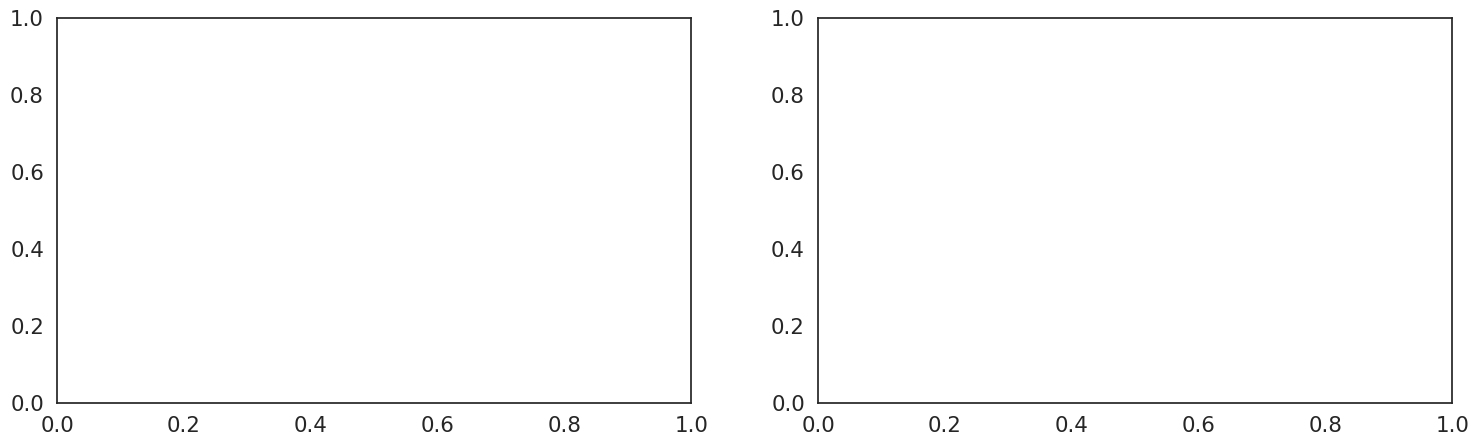

In [49]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [ ]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set (Aggregated by Subject)

    rnn_model.eval()
    test_preds = []

    with torch.no_grad():
        # Inferenza batch-by-batch sugli array X_test
        for i in range(0, len(X_test), 256):   # puoi modificare la batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    # Concatena i batch
    test_preds = np.concatenate(test_preds)       # (N_windows, C)

    # --- Generate subj_ids for X_test ---
    # This is crucial because `subj_ids` previously was for X_test_s (211840 rows)
    # while X_test and y_test are for df_test (12800 rows).
    subj_ids_test = make_subj_ids(df_test, WINDOW_SIZE, STRIDE)

    # --- Aggregazione per pirata (sample_index) ---
    unique_ids = np.unique(subj_ids_test) # Use subj_ids_test here
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = subj_ids_test == sid # Use subj_ids_test here
        probs_sid = test_preds[mask]          # (N_windows_subject, C)
        y_true_sid = y_test[mask][0]          # stessa label per tutte le finestre del soggetto
        probs_agg = np.mean(probs_sid, axis=0)  # usa la media; puoi provare np.median
        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)

    # --- Metriche globali ---
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set: {test_acc:.4f}")
    print(f"Precision over the test set: {test_prec:.4f}")
    print(f"Recall over the test set: {test_rec:.4f}")
    print(f"F1 score over the test set: {test_f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set (Aggregated by Subject)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Test Set Confusion Matrix for RNN as N_TEST_USERS is {N_TEST_USERS}")

In [ ]:
# @title Generate Submission File for X_test_s

# Ensure the model is in evaluation mode
rnn_model.eval()

# List to store predictions for all windows in X_test_s
test_s_window_preds = []

with torch.no_grad():
    # Iterate through X_test_s in batches for inference
    for i in range(0, len(X_test_s), 256):  # Using a batch size of 256 for inference
        # Create a tensor from the batch of data, move to device
        xb = torch.tensor(X_test_s[i:i+256], dtype=torch.float32, device=device)

        # Perform forward pass to get logits
        logits = rnn_model(xb)

        # Apply softmax to get probabilities and convert to numpy
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store the probabilities for each window
        test_s_window_preds.append(probs)

# Concatenate all batch predictions into a single array
test_s_window_preds = np.concatenate(test_s_window_preds) # Shape: (N_windows, num_classes)

# --- Aggregation per subject (sample_index) ---
# The 'subj_ids' array already generated from df_test_s in an earlier cell (hJfdTVU8MWq9)
# is appropriate here.

# Get unique sample indices from the test submission data
unique_sample_indices = np.unique(subj_ids)

final_predictions = []

for sid in unique_sample_indices:
    # Get the mask for the current sample_index
    mask = subj_ids == sid

    # Select the probabilities for all windows belonging to this sample_index
    probs_for_subject = test_s_window_preds[mask]

    # Aggregate probabilities by taking the mean across all windows for this subject
    # This gives a single probability distribution over classes for the subject
    aggregated_probs = np.mean(probs_for_subject, axis=0)

    # The final prediction is the class with the highest aggregated probability
    predicted_label_index = np.argmax(aggregated_probs)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# Convert to DataFrame
submission_df = pd.DataFrame(final_predictions)

# Map integer labels back to original string labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

# Construct the full path for the submission file in Google Drive
submission_file_path = os.path.join(current_dir.replace('\\', ''), 'submission_rnn.csv')

# Select only the required columns and save to CSV in Google Drive
submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

### **Bidirectional Recurrent Neural Network (BiRNN)**

<img src="https://drive.google.com/uc?export=view&id=1fU-SHapy-u1xHg8F-JApdOoX9Pz6kRmD" width="800"/>

In [ ]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "bi_rnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="bi_rnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set (Aggregated by Subject)

    rnn_model.eval()
    test_preds = []

    with torch.no_grad():
        # Inferenza batch-by-batch sugli array X_test
        for i in range(0, len(X_test), 256):   # puoi modificare la batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    # Concatena i batch
    test_preds = np.concatenate(test_preds)       # (N_windows, C)

    # --- Generate subj_ids for X_test ---
    # This is crucial because `subj_ids` previously was for X_test_s (211840 rows)
    # while X_test and y_test are for df_test (12800 rows).
    subj_ids_test = make_subj_ids(df_test, WINDOW_SIZE, STRIDE)

    # --- Aggregazione per pirata (sample_index) ---
    unique_ids = np.unique(subj_ids_test) # Use subj_ids_test here
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = subj_ids_test == sid # Use subj_ids_test here
        probs_sid = test_preds[mask]          # (N_windows_subject, C)
        y_true_sid = y_test[mask][0]          # stessa label per tutte le finestre del soggetto
        probs_agg = np.mean(probs_sid, axis=0)  # usa la media; puoi provare np.median
        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)

    # --- Metriche globali ---
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set: {test_acc:.4f}")
    print(f"Precision over the test set: {test_prec:.4f}")
    print(f"Recall over the test set: {test_rec:.4f}")
    print(f"F1 score over the test set: {test_f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set (Aggregated by Subject)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Test Set Confusion Matrix for BiRNN as N_TEST_USERS is {N_TEST_USERS}")

In [ ]:
# @title Generate Submission File for X_test_s

# Ensure the model is in evaluation mode
rnn_model.eval()

# List to store predictions for all windows in X_test_s
test_s_window_preds = []

with torch.no_grad():
    # Iterate through X_test_s in batches for inference
    for i in range(0, len(X_test_s), 256):  # Using a batch size of 256 for inference
        # Create a tensor from the batch of data, move to device
        xb = torch.tensor(X_test_s[i:i+256], dtype=torch.float32, device=device)

        # Perform forward pass to get logits
        logits = rnn_model(xb)

        # Apply softmax to get probabilities and convert to numpy
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store the probabilities for each window
        test_s_window_preds.append(probs)

# Concatenate all batch predictions into a single array
test_s_window_preds = np.concatenate(test_s_window_preds) # Shape: (N_windows, num_classes)

# --- Aggregation per subject (sample_index) ---
# The 'subj_ids' array already generated from df_test_s in an earlier cell (hJfdTVU8MWq9)
# is appropriate here.

# Get unique sample indices from the test submission data
unique_sample_indices = np.unique(subj_ids)

final_predictions = []

for sid in unique_sample_indices:
    # Get the mask for the current sample_index
    mask = subj_ids == sid

    # Select the probabilities for all windows belonging to this sample_index
    probs_for_subject = test_s_window_preds[mask]

    # Aggregate probabilities by taking the mean across all windows for this subject
    # This gives a single probability distribution over classes for the subject
    aggregated_probs = np.mean(probs_for_subject, axis=0)

    # The final prediction is the class with the highest aggregated probability
    predicted_label_index = np.argmax(aggregated_probs)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# Convert to DataFrame
submission_df = pd.DataFrame(final_predictions)

# Map integer labels back to original string labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

# Construct the full path for the submission file in Google Drive
submission_file_path = os.path.join(current_dir.replace('\\', ''), 'submission_rnn_bi.csv')

# Select only the required columns and save to CSV in Google Drive
submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

### **Long Short-Term Memory (LSTM)**

<img src="https://drive.google.com/uc?export=view&id=1AHDpl1vMWow9xUhP4C7nZLJjk_kNos_I" width="800"/>

In [87]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='LSTM'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "lstm"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 40, 128], [2, -1, 128]] 217,600        
classifier (Linear)       [-1, 3]                      387            
Total params: 217,987
Trainable params: 217,987
Non-trainable params: 0
-------------------------------------------------------------------------------


In [88]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="lstm",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0941, F1 Score=0.5991 | Val: Loss=1.1809, F1 Score=0.4901
Epoch   2/500 | Train: Loss=0.9976, F1 Score=0.7228 | Val: Loss=1.0050, F1 Score=0.7249
Epoch   3/500 | Train: Loss=0.9549, F1 Score=0.7419 | Val: Loss=0.9901, F1 Score=0.7095
Epoch   4/500 | Train: Loss=0.9191, F1 Score=0.7532 | Val: Loss=1.0305, F1 Score=0.7207
Epoch   5/500 | Train: Loss=0.9226, F1 Score=0.7440 | Val: Loss=1.0082, F1 Score=0.7212
Epoch   6/500 | Train: Loss=0.8825, F1 Score=0.7507 | Val: Loss=1.0133, F1 Score=0.6559
Epoch   7/500 | Train: Loss=0.9051, F1 Score=0.7467 | Val: Loss=0.9703, F1 Score=0.7038
Epoch   8/500 | Train: Loss=0.8695, F1 Score=0.7410 | Val: Loss=1.0925, F1 Score=0.7192
Epoch   9/500 | Train: Loss=0.8432, F1 Score=0.7171 | Val: Loss=1.0621, F1 Score=0.7219
Epoch  10/500 | Train: Loss=0.8157, F1 Score=0.7423 | Val: Loss=0.8963, F1 Score=0.8263
Epoch  11/500 | Train: Loss=0.7880, F1 Score=0.6917 | Val: Loss=1.0460, F1 Score=0.4144
Epoch  12

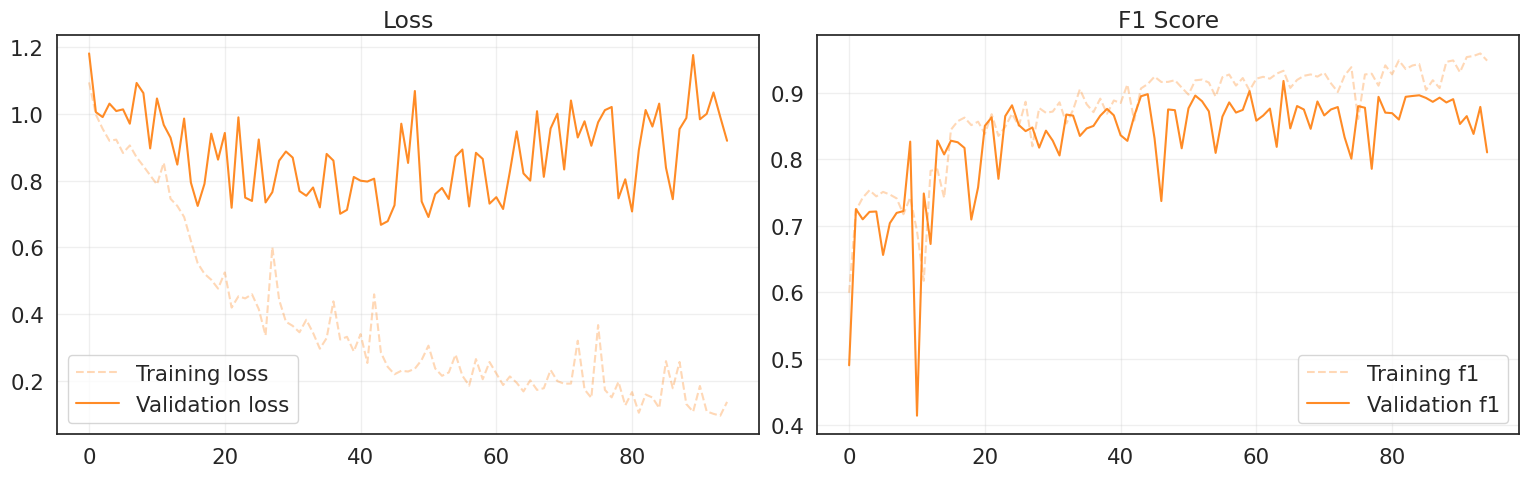

In [89]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

=== Validation — Per Window ===
Accuracy:  0.9200
Precision: 0.9174
Recall:    0.9200
F1 score:  0.9175


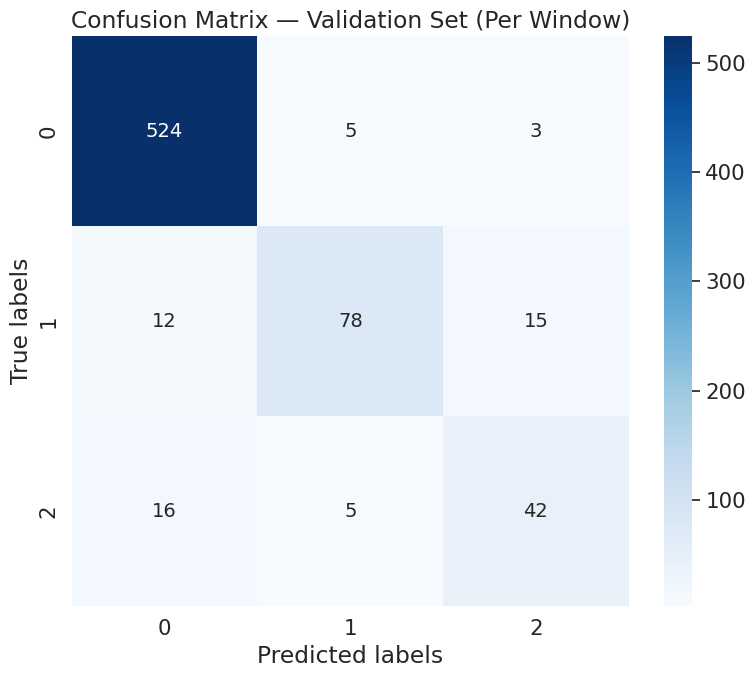


=== Validation — Aggregated by Subject ===
Accuracy:  0.9300
Precision: 0.9306
Recall:    0.9300
F1 score:  0.9262


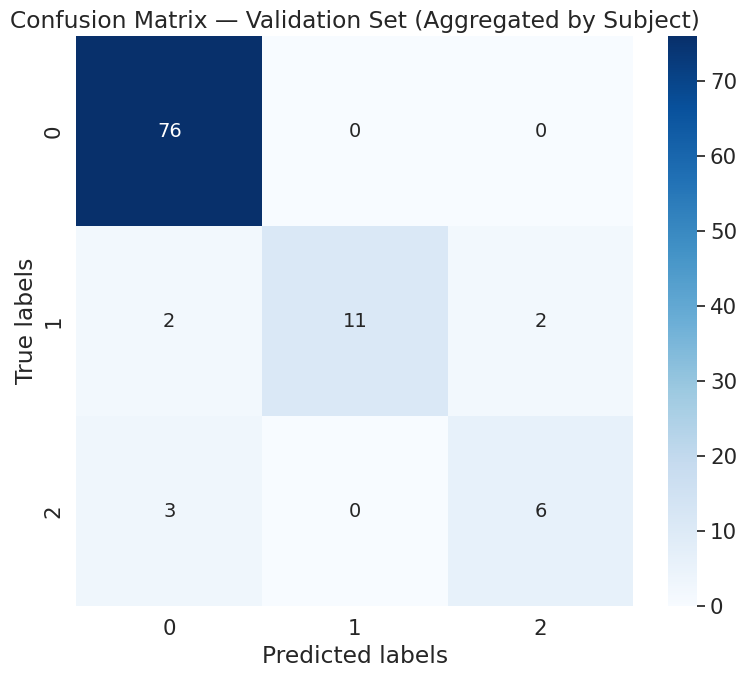

In [90]:
# @title Plot Confusion Matrices — Validation Set (Per Window & Aggregated by Subject)

rnn_model.eval()

val_probs_list = []
val_targets_list = []

with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model logits
        logits = rnn_model(xb)

        # Probabilità con softmax (per aggregazione)
        probs = torch.softmax(logits, dim=1)

        # Salvo batch di probabilità e target
        val_probs_list.append(probs.cpu().numpy())
        val_targets_list.append(yb.numpy())

# Combine all batches into single arrays
val_probs   = np.concatenate(val_probs_list, axis=0)   # shape: (N_windows, C)
val_targets = np.concatenate(val_targets_list, axis=0) # shape: (N_windows,)

# ===============================
# 1) CONFUSION MATRIX PER FINESTRA
# ===============================

# Predizioni per finestra (come nel blocco originale)
val_preds_window = val_probs.argmax(axis=1)

# Metriche per finestra
val_acc_w  = accuracy_score(val_targets, val_preds_window)
val_prec_w = precision_score(val_targets, val_preds_window, average='weighted')
val_rec_w  = recall_score(val_targets, val_preds_window, average='weighted')
val_f1_w   = f1_score(val_targets, val_preds_window, average='weighted')

print("=== Validation — Per Window ===")
print(f"Accuracy:  {val_acc_w:.4f}")
print(f"Precision: {val_prec_w:.4f}")
print(f"Recall:    {val_rec_w:.4f}")
print(f"F1 score:  {val_f1_w:.4f}")

# Confusion matrix per finestra
cm_window = confusion_matrix(val_targets, val_preds_window)
labels_window = np.array([f"{num}" for num in cm_window.flatten()]).reshape(cm_window.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_window, annot=labels_window, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Per Window)')
plt.tight_layout()
plt.show()

# ====================================
# 2) CONFUSION MATRIX AGGREGATA PER SOGGETTO
# ====================================

# Genero gli ID soggetto per il validation set
# (devono avere stessa lunghezza di val_probs / val_targets)
subj_ids_val = make_subj_ids(df_val, WINDOW_SIZE, STRIDE)
assert len(subj_ids_val) == len(val_targets), "subj_ids_val deve avere stessa lunghezza di val_targets!"

unique_ids = np.unique(subj_ids_val)
final_preds, final_targets = [], []

for sid in unique_ids:
    mask = (subj_ids_val == sid)
    probs_sid = val_probs[mask]        # (N_windows_subject, C)
    y_true_sid = val_targets[mask][0]  # stessa label per tutte le finestre del soggetto

    # Aggregazione delle finestre del soggetto (media delle probabilità)
    probs_agg = np.mean(probs_sid, axis=0)
    y_pred_sid = np.argmax(probs_agg)

    final_preds.append(y_pred_sid)
    final_targets.append(y_true_sid)

final_preds   = np.array(final_preds)
final_targets = np.array(final_targets)

# Metriche globali per soggetto
val_acc_s  = accuracy_score(final_targets, final_preds)
val_prec_s = precision_score(final_targets, final_preds, average='weighted')
val_rec_s  = recall_score(final_targets, final_preds, average='weighted')
val_f1_s   = f1_score(final_targets, final_preds, average='weighted')

print("\n=== Validation — Aggregated by Subject ===")
print(f"Accuracy:  {val_acc_s:.4f}")
print(f"Precision: {val_prec_s:.4f}")
print(f"Recall:    {val_rec_s:.4f}")
print(f"F1 score:  {val_f1_s:.4f}")

# Confusion matrix per soggetto
cm_subj = confusion_matrix(final_targets, final_preds)
labels_subj = np.array([f"{num}" for num in cm_subj.flatten()]).reshape(cm_subj.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_subj, annot=labels_subj, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Aggregated by Subject)')
plt.tight_layout()
plt.show()

In [91]:
# @title Generate Submission File for X_test_s

# Ensure the model is in evaluation mode
rnn_model.eval()

# List to store predictions for all windows in X_test_s
test_s_window_preds = []

with torch.no_grad():
    # Iterate through X_test_s in batches for inference
    for i in range(0, len(X_test_s), 256):  # Using a batch size of 256 for inference
        # Create a tensor from the batch of data, move to device
        xb = torch.tensor(X_test_s[i:i+256], dtype=torch.float32, device=device)

        # Perform forward pass to get logits
        logits = rnn_model(xb)

        # Apply softmax to get probabilities and convert to numpy
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store the probabilities for each window
        test_s_window_preds.append(probs)

# Concatenate all batch predictions into a single array
test_s_window_preds = np.concatenate(test_s_window_preds) # Shape: (N_windows, num_classes)

# --- Aggregation per subject (sample_index) ---
# The 'subj_ids' array already generated from df_test_s in an earlier cell (hJfdTVU8MWq9)
# is appropriate here.

# Get unique sample indices from the test submission data
unique_sample_indices = np.unique(subj_ids)

final_predictions = []

for sid in unique_sample_indices:
    # Get the mask for the current sample_index
    mask = subj_ids == sid

    # Select the probabilities for all windows belonging to this sample_index
    probs_for_subject = test_s_window_preds[mask]

    # Aggregate probabilities by taking the mean across all windows for this subject
    # This gives a single probability distribution over classes for the subject
    aggregated_probs = np.mean(probs_for_subject, axis=0)

    # The final prediction is the class with the highest aggregated probability
    predicted_label_index = np.argmax(aggregated_probs)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# Convert to DataFrame
submission_df = pd.DataFrame(final_predictions)

# Map integer labels back to original string labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

# Construct the full path for the submission file in Google Drive
submission_file_path = os.path.join(current_dir.replace('\\', ''), 'submission_lstm.csv')

# Select only the required columns and save to CSV in Google Drive
submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_lstm.csv' created successfully.
   sample_index  predicted_label_index    label
0             0                      0  no_pain
1             1                      0  no_pain
2             2                      0  no_pain
3             3                      0  no_pain
4             4                      0  no_pain


In [92]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set (Aggregated by Subject)

    rnn_model.eval()
    test_preds = []

    with torch.no_grad():
        # Inferenza batch-by-batch sugli array X_test
        for i in range(0, len(X_test), 256):   # puoi modificare la batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    # Concatena i batch
    test_preds = np.concatenate(test_preds)       # (N_windows, C)

    # --- Generate subj_ids for X_test ---
    # This is crucial because `subj_ids` previously was for X_test_s (211840 rows)
    # while X_test and y_test are for df_test (12800 rows).
    subj_ids_test = make_subj_ids(df_test, WINDOW_SIZE, STRIDE)

    # --- Aggregazione per pirata (sample_index) ---
    unique_ids = np.unique(subj_ids_test) # Use subj_ids_test here
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = subj_ids_test == sid # Use subj_ids_test here
        probs_sid = test_preds[mask]          # (N_windows_subject, C)
        y_true_sid = y_test[mask][0]          # stessa label per tutte le finestre del soggetto
        probs_agg = np.mean(probs_sid, axis=0)  # usa la media; puoi provare np.median
        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)

    # --- Metriche globali ---
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set: {test_acc:.4f}")
    print(f"Precision over the test set: {test_prec:.4f}")
    print(f"Recall over the test set: {test_rec:.4f}")
    print(f"F1 score over the test set: {test_f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set (Aggregated by Subject)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Test Set Confusion Matrix for LSTM as N_TEST_USERS is {N_TEST_USERS}")

Skipping Test Set Confusion Matrix for LSTM as N_TEST_USERS is 0


In [93]:
# @title Generate Submission File for X_test_s

# Ensure the model is in evaluation mode
rnn_model.eval()

# List to store predictions for all windows in X_test_s
test_s_window_preds = []

with torch.no_grad():
    # Iterate through X_test_s in batches for inference
    for i in range(0, len(X_test_s), 256):  # Using a batch size of 256 for inference
        # Create a tensor from the batch of data, move to device
        xb = torch.tensor(X_test_s[i:i+256], dtype=torch.float32, device=device)

        # Perform forward pass to get logits
        logits = rnn_model(xb)

        # Apply softmax to get probabilities and convert to numpy
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store the probabilities for each window
        test_s_window_preds.append(probs)

# Concatenate all batch predictions into a single array
test_s_window_preds = np.concatenate(test_s_window_preds) # Shape: (N_windows, num_classes)

# --- Aggregation per subject (sample_index) ---
# The 'subj_ids' array already generated from df_test_s in an earlier cell (hJfdTVU8MWq9)
# is appropriate here.

# Get unique sample indices from the test submission data
unique_sample_indices = np.unique(subj_ids)

final_predictions = []

for sid in unique_sample_indices:
    # Get the mask for the current sample_index
    mask = subj_ids == sid

    # Select the probabilities for all windows belonging to this sample_index
    probs_for_subject = test_s_window_preds[mask]

    # Aggregate probabilities by taking the mean across all windows for this subject
    # This gives a single probability distribution over classes for the subject
    aggregated_probs = np.mean(probs_for_subject, axis=0)

    # The final prediction is the class with the highest aggregated probability
    predicted_label_index = np.argmax(aggregated_probs)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# Convert to DataFrame
submission_df = pd.DataFrame(final_predictions)

# Map integer labels back to original string labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

# Construct the full path for the submission file in Google Drive
submission_file_path = os.path.join(current_dir.replace('\\', ''), 'submission_lstm_bi.csv')

# Select only the required columns and save to CSV in Google Drive
submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_lstm_bi.csv' created successfully.
   sample_index  predicted_label_index    label
0             0                      0  no_pain
1             1                      0  no_pain
2             2                      0  no_pain
3             3                      0  no_pain
4             4                      0  no_pain


### **Bidirectional Long Short-Term Memory (BiLSTM)**

<img src="https://drive.google.com/uc?export=view&id=1-W_s-cH_9wv-rmfKaa5giXzIXpdRFUpf" width="800"/>

In [65]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "bi_lstm"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 40, 256], [4, -1, 128]] 566,272        
classifier (Linear)       [-1, 3]                      771            
Total params: 567,043
Trainable params: 567,043
Non-trainable params: 0
-------------------------------------------------------------------------------


In [66]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="bi_lstm",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0636, F1 Score=0.6044 | Val: Loss=0.9879, F1 Score=0.7323
Epoch   2/500 | Train: Loss=0.9898, F1 Score=0.6770 | Val: Loss=0.9975, F1 Score=0.7337
Epoch   3/500 | Train: Loss=0.9025, F1 Score=0.7059 | Val: Loss=0.9085, F1 Score=0.7734
Epoch   4/500 | Train: Loss=0.8031, F1 Score=0.7788 | Val: Loss=0.8496, F1 Score=0.7311
Epoch   5/500 | Train: Loss=0.7873, F1 Score=0.7865 | Val: Loss=0.7692, F1 Score=0.8073
Epoch   6/500 | Train: Loss=0.7186, F1 Score=0.8276 | Val: Loss=0.7905, F1 Score=0.8032
Epoch   7/500 | Train: Loss=0.6574, F1 Score=0.8236 | Val: Loss=0.8467, F1 Score=0.8076
Epoch   8/500 | Train: Loss=0.6047, F1 Score=0.8298 | Val: Loss=0.7995, F1 Score=0.8319
Epoch   9/500 | Train: Loss=0.5964, F1 Score=0.8208 | Val: Loss=0.9392, F1 Score=0.8010
Epoch  10/500 | Train: Loss=0.5901, F1 Score=0.8191 | Val: Loss=1.0776, F1 Score=0.7988
Epoch  11/500 | Train: Loss=0.5464, F1 Score=0.8338 | Val: Loss=0.8950, F1 Score=0.8063
Epoch  12

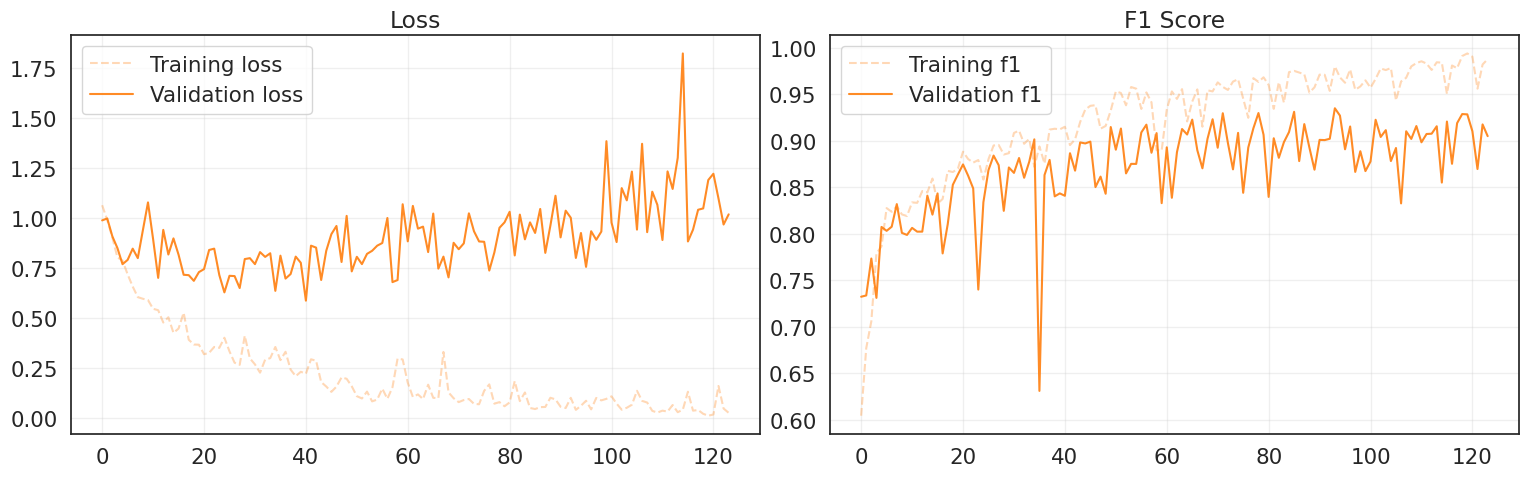

In [67]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9357
Precision over the validation set: 0.9350
Recall over the validation set: 0.9357
F1 score over the validation set: 0.9350


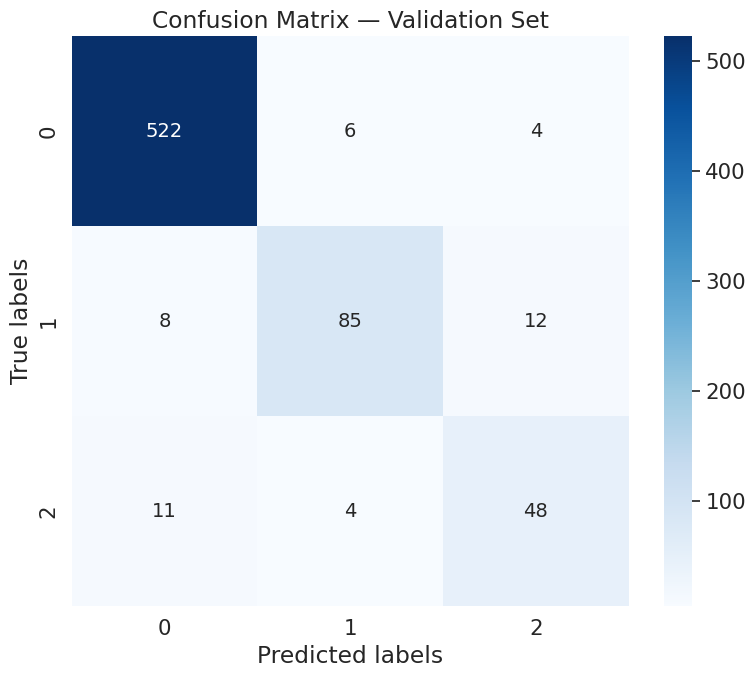

In [68]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [69]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set (Aggregated by Subject)

    rnn_model.eval()
    test_preds = []

    with torch.no_grad():
        # Inferenza batch-by-batch sugli array X_test
        for i in range(0, len(X_test), 256):   # puoi modificare la batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    # Concatena i batch
    test_preds = np.concatenate(test_preds)       # (N_windows, C)

    # --- Generate subj_ids for X_test ---
    # This is crucial because `subj_ids` previously was for X_test_s (211840 rows)
    # while X_test and y_test are for df_test (12800 rows).
    subj_ids_test = make_subj_ids(df_test, WINDOW_SIZE, STRIDE)

    # --- Aggregazione per pirata (sample_index) ---
    unique_ids = np.unique(subj_ids_test) # Use subj_ids_test here
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = subj_ids_test == sid # Use subj_ids_test here
        probs_sid = test_preds[mask]          # (N_windows_subject, C)
        y_true_sid = y_test[mask][0]          # stessa label per tutte le finestre del soggetto
        probs_agg = np.mean(probs_sid, axis=0)  # usa la media; puoi provare np.median
        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)

    # --- Metriche globali ---
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set: {test_acc:.4f}")
    print(f"Precision over the test set: {test_prec:.4f}")
    print(f"Recall over the test set: {test_rec:.4f}")
    print(f"F1 score over the test set: {test_f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set (Aggregated by Subject)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Test Set Confusion Matrix for LSTM as N_TEST_USERS is {N_TEST_USERS}")

Skipping Test Set Confusion Matrix for LSTM as N_TEST_USERS is 0


In [70]:
# @title Generate Submission File for X_test_s

# Ensure the model is in evaluation mode
rnn_model.eval()

# List to store predictions for all windows in X_test_s
test_s_window_preds = []

with torch.no_grad():
    # Iterate through X_test_s in batches for inference
    for i in range(0, len(X_test_s), 256):  # Using a batch size of 256 for inference
        # Create a tensor from the batch of data, move to device
        xb = torch.tensor(X_test_s[i:i+256], dtype=torch.float32, device=device)

        # Perform forward pass to get logits
        logits = rnn_model(xb)

        # Apply softmax to get probabilities and convert to numpy
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store the probabilities for each window
        test_s_window_preds.append(probs)

# Concatenate all batch predictions into a single array
test_s_window_preds = np.concatenate(test_s_window_preds) # Shape: (N_windows, num_classes)

# --- Aggregation per subject (sample_index) ---
# The 'subj_ids' array already generated from df_test_s in an earlier cell (hJfdTVU8MWq9)
# is appropriate here.

# Get unique sample indices from the test submission data
unique_sample_indices = np.unique(subj_ids)

final_predictions = []

for sid in unique_sample_indices:
    # Get the mask for the current sample_index
    mask = subj_ids == sid

    # Select the probabilities for all windows belonging to this sample_index
    probs_for_subject = test_s_window_preds[mask]

    # Aggregate probabilities by taking the mean across all windows for this subject
    # This gives a single probability distribution over classes for the subject
    aggregated_probs = np.mean(probs_for_subject, axis=0)

    # The final prediction is the class with the highest aggregated probability
    predicted_label_index = np.argmax(aggregated_probs)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# Convert to DataFrame
submission_df = pd.DataFrame(final_predictions)

# Map integer labels back to original string labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

# Construct the full path for the submission file in Google Drive
submission_file_path = os.path.join(current_dir.replace('\\', ''), 'submission_lstm_bi.csv')

# Select only the required columns and save to CSV in Google Drive
submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_lstm_bi.csv' created successfully.
   sample_index  predicted_label_index    label
0             0                      0  no_pain
1             1                      0  no_pain
2             2                      0  no_pain
3             3                      0  no_pain
4             4                      0  no_pain


### **Gated Recurrent Unit (GRU)**

<img src="https://drive.google.com/uc?export=view&id=1Ux7kRpO_9zgPfxITPjAsRZEOuVcJZVgg" width="1000"/>

In [78]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='GRU'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "gru"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 40, 128], [2, -1, 128]] 163,200        
classifier (Linear)       [-1, 3]                      387            
Total params: 163,587
Trainable params: 163,587
Non-trainable params: 0
-------------------------------------------------------------------------------


In [79]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="gru",
    patience=20
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0740, F1 Score=0.5767 | Val: Loss=1.0194, F1 Score=0.6203
Epoch   2/500 | Train: Loss=0.9688, F1 Score=0.7210 | Val: Loss=0.9691, F1 Score=0.7302
Epoch   3/500 | Train: Loss=0.9471, F1 Score=0.7033 | Val: Loss=0.9819, F1 Score=0.6177
Epoch   4/500 | Train: Loss=0.8847, F1 Score=0.7168 | Val: Loss=0.9221, F1 Score=0.4716
Epoch   5/500 | Train: Loss=0.8691, F1 Score=0.7077 | Val: Loss=0.9294, F1 Score=0.6498
Epoch   6/500 | Train: Loss=0.8517, F1 Score=0.7244 | Val: Loss=0.8851, F1 Score=0.7489
Epoch   7/500 | Train: Loss=0.7994, F1 Score=0.7355 | Val: Loss=0.8762, F1 Score=0.5942
Epoch   8/500 | Train: Loss=0.7465, F1 Score=0.7625 | Val: Loss=0.9241, F1 Score=0.8353
Epoch   9/500 | Train: Loss=0.6899, F1 Score=0.7995 | Val: Loss=0.8044, F1 Score=0.7857
Epoch  10/500 | Train: Loss=0.6148, F1 Score=0.8320 | Val: Loss=0.7330, F1 Score=0.8195
Epoch  11/500 | Train: Loss=0.6073, F1 Score=0.8200 | Val: Loss=0.8009, F1 Score=0.8228
Epoch  12

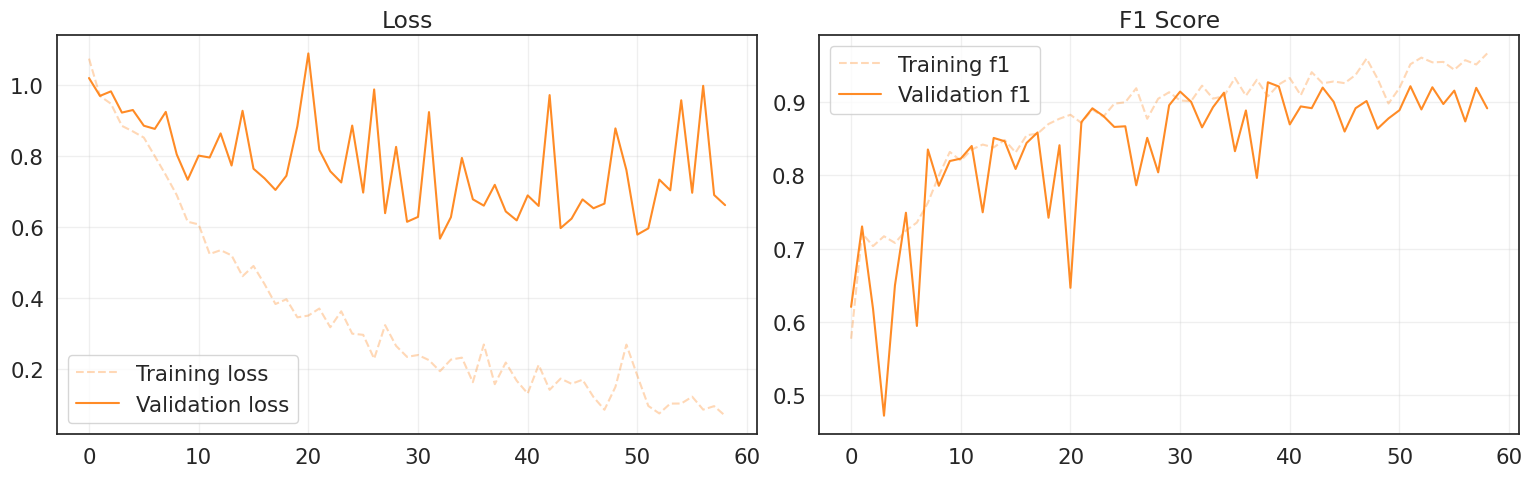

In [80]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

=== Validation — Per Window ===
Accuracy:  0.9300
Precision: 0.9300
Recall:    0.9300
F1 score:  0.9271


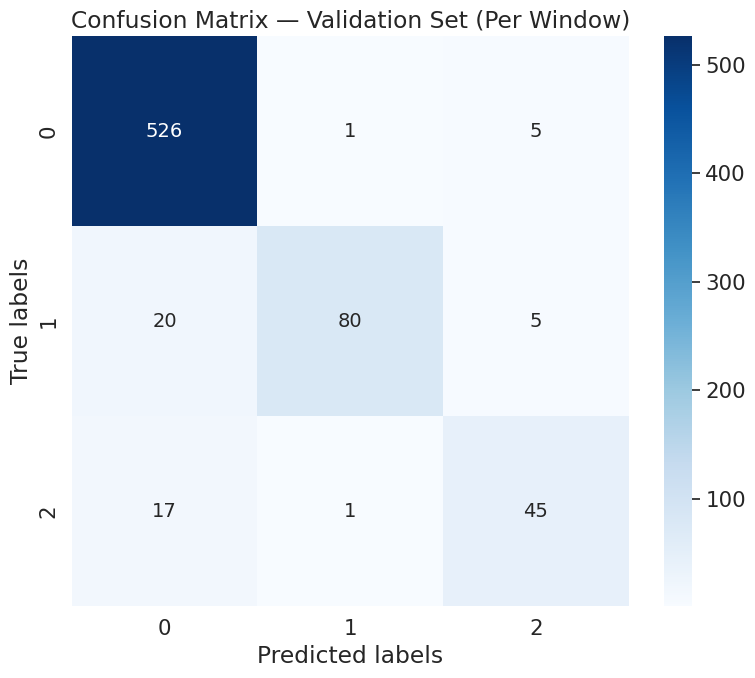


=== Validation — Aggregated by Subject ===
Accuracy:  0.9500
Precision: 0.9507
Recall:    0.9500
F1 score:  0.9480


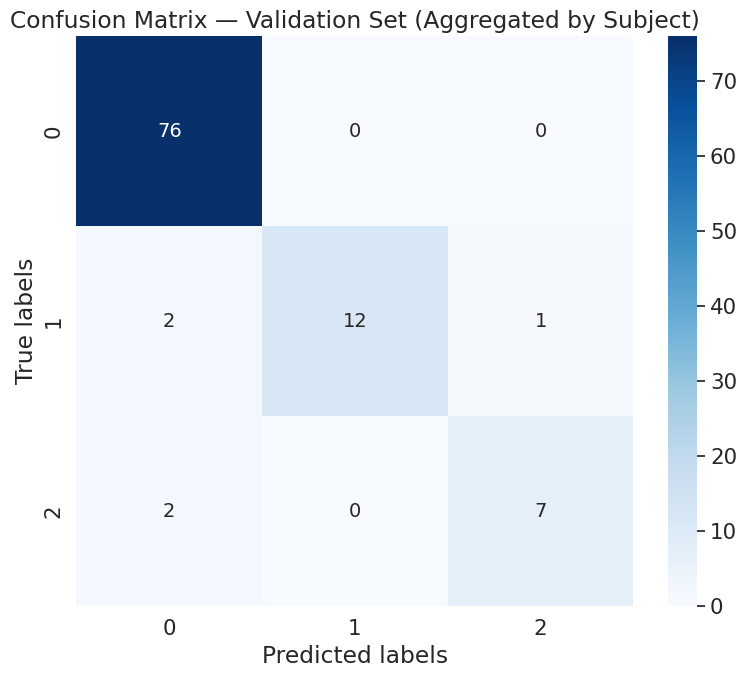

In [85]:
# @title Plot Confusion Matrices — Validation Set (Per Window & Aggregated by Subject)

rnn_model.eval()

val_probs_list = []
val_targets_list = []

with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model logits
        logits = rnn_model(xb)

        # Probabilità con softmax (per aggregazione)
        probs = torch.softmax(logits, dim=1)

        # Salvo batch di probabilità e target
        val_probs_list.append(probs.cpu().numpy())
        val_targets_list.append(yb.numpy())

# Combine all batches into single arrays
val_probs   = np.concatenate(val_probs_list, axis=0)   # shape: (N_windows, C)
val_targets = np.concatenate(val_targets_list, axis=0) # shape: (N_windows,)

# ===============================
# 1) CONFUSION MATRIX PER FINESTRA
# ===============================

# Predizioni per finestra (come nel blocco originale)
val_preds_window = val_probs.argmax(axis=1)

# Metriche per finestra
val_acc_w  = accuracy_score(val_targets, val_preds_window)
val_prec_w = precision_score(val_targets, val_preds_window, average='weighted')
val_rec_w  = recall_score(val_targets, val_preds_window, average='weighted')
val_f1_w   = f1_score(val_targets, val_preds_window, average='weighted')

print("=== Validation — Per Window ===")
print(f"Accuracy:  {val_acc_w:.4f}")
print(f"Precision: {val_prec_w:.4f}")
print(f"Recall:    {val_rec_w:.4f}")
print(f"F1 score:  {val_f1_w:.4f}")

# Confusion matrix per finestra
cm_window = confusion_matrix(val_targets, val_preds_window)
labels_window = np.array([f"{num}" for num in cm_window.flatten()]).reshape(cm_window.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_window, annot=labels_window, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Per Window)')
plt.tight_layout()
plt.show()

# ====================================
# 2) CONFUSION MATRIX AGGREGATA PER SOGGETTO
# ====================================

# Genero gli ID soggetto per il validation set
# (devono avere stessa lunghezza di val_probs / val_targets)
subj_ids_val = make_subj_ids(df_val, WINDOW_SIZE, STRIDE)
assert len(subj_ids_val) == len(val_targets), "subj_ids_val deve avere stessa lunghezza di val_targets!"

unique_ids = np.unique(subj_ids_val)
final_preds, final_targets = [], []

for sid in unique_ids:
    mask = (subj_ids_val == sid)
    probs_sid = val_probs[mask]        # (N_windows_subject, C)
    y_true_sid = val_targets[mask][0]  # stessa label per tutte le finestre del soggetto

    # Aggregazione delle finestre del soggetto (media delle probabilità)
    probs_agg = np.mean(probs_sid, axis=0)
    y_pred_sid = np.argmax(probs_agg)

    final_preds.append(y_pred_sid)
    final_targets.append(y_true_sid)

final_preds   = np.array(final_preds)
final_targets = np.array(final_targets)

# Metriche globali per soggetto
val_acc_s  = accuracy_score(final_targets, final_preds)
val_prec_s = precision_score(final_targets, final_preds, average='weighted')
val_rec_s  = recall_score(final_targets, final_preds, average='weighted')
val_f1_s   = f1_score(final_targets, final_preds, average='weighted')

print("\n=== Validation — Aggregated by Subject ===")
print(f"Accuracy:  {val_acc_s:.4f}")
print(f"Precision: {val_prec_s:.4f}")
print(f"Recall:    {val_rec_s:.4f}")
print(f"F1 score:  {val_f1_s:.4f}")

# Confusion matrix per soggetto
cm_subj = confusion_matrix(final_targets, final_preds)
labels_subj = np.array([f"{num}" for num in cm_subj.flatten()]).reshape(cm_subj.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_subj, annot=labels_subj, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Aggregated by Subject)')
plt.tight_layout()
plt.show()

In [63]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set (Aggregated by Subject)

    rnn_model.eval()
    test_preds = []

    with torch.no_grad():
        # Inferenza batch-by-batch sugli array X_test
        for i in range(0, len(X_test), 256):   # puoi modificare la batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    # Concatena i batch
    test_preds = np.concatenate(test_preds)       # (N_windows, C)

    # --- Generate subj_ids for X_test ---
    # This is crucial because `subj_ids` previously was for X_test_s (211840 rows)
    # while X_test and y_test are for df_test (12800 rows).
    subj_ids_test = make_subj_ids(df_test, WINDOW_SIZE, STRIDE)

    # --- Aggregazione per pirata (sample_index) ---
    unique_ids = np.unique(subj_ids_test) # Use subj_ids_test here
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = subj_ids_test == sid # Use subj_ids_test here
        probs_sid = test_preds[mask]          # (N_windows_subject, C)
        y_true_sid = y_test[mask][0]          # stessa label per tutte le finestre del soggetto
        probs_agg = np.mean(probs_sid, axis=0)  # usa la media; puoi provare np.median
        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)

    # --- Metriche globali ---
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set: {test_acc:.4f}")
    print(f"Precision over the test set: {test_prec:.4f}")
    print(f"Recall over the test set: {test_rec:.4f}")
    print(f"F1 score over the test set: {test_f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set (Aggregated by Subject)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Test Set Confusion Matrix for LSTM as N_TEST_USERS is {N_TEST_USERS}")

Skipping Test Set Confusion Matrix for LSTM as N_TEST_USERS is 0


In [64]:
# @title Generate Submission File for X_test_s

# Ensure the model is in evaluation mode
rnn_model.eval()

# List to store predictions for all windows in X_test_s
test_s_window_preds = []

with torch.no_grad():
    # Iterate through X_test_s in batches for inference
    for i in range(0, len(X_test_s), 256):  # Using a batch size of 256 for inference
        # Create a tensor from the batch of data, move to device
        xb = torch.tensor(X_test_s[i:i+256], dtype=torch.float32, device=device)

        # Perform forward pass to get logits
        logits = rnn_model(xb)

        # Apply softmax to get probabilities and convert to numpy
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store the probabilities for each window
        test_s_window_preds.append(probs)

# Concatenate all batch predictions into a single array
test_s_window_preds = np.concatenate(test_s_window_preds) # Shape: (N_windows, num_classes)

# --- Aggregation per subject (sample_index) ---
# The 'subj_ids' array already generated from df_test_s in an earlier cell (hJfdTVU8MWq9)
# is appropriate here.

# Get unique sample indices from the test submission data
unique_sample_indices = np.unique(subj_ids)

final_predictions = []

for sid in unique_sample_indices:
    # Get the mask for the current sample_index
    mask = subj_ids == sid

    # Select the probabilities for all windows belonging to this sample_index
    probs_for_subject = test_s_window_preds[mask]

    # Aggregate probabilities by taking the mean across all windows for this subject
    # This gives a single probability distribution over classes for the subject
    aggregated_probs = np.mean(probs_for_subject, axis=0)

    # The final prediction is the class with the highest aggregated probability
    predicted_label_index = np.argmax(aggregated_probs)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# Convert to DataFrame
submission_df = pd.DataFrame(final_predictions)

# Map integer labels back to original string labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

# Construct the full path for the submission file in Google Drive
submission_file_path = os.path.join(current_dir.replace('\\', ''), 'submission_gru.csv')

# Select only the required columns and save to CSV in Google Drive
submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_gru.csv' created successfully.
   sample_index  predicted_label_index    label
0             0                      0  no_pain
1             1                      0  no_pain
2             2                      0  no_pain
3             3                      0  no_pain
4             4                      0  no_pain


### **Bidirectional Gated Recurrent Unit (BiGRU)**

<img src="https://drive.google.com/uc?export=view&id=1KH9dzVdNpSftSvWb2IXkBNcXAWwWVdhw" width="800"/>

In [50]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='GRU'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "bi_gru"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 40, 256], [4, -1, 128]] 424,704        
classifier (Linear)       [-1, 3]                      771            
Total params: 425,475
Trainable params: 425,475
Non-trainable params: 0
-------------------------------------------------------------------------------


In [51]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="bi_gru",
    patience=PATIENCE # Use the global PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0796, F1 Score=0.5522 | Val: Loss=1.0173, F1 Score=0.6609
Epoch   2/500 | Train: Loss=0.9909, F1 Score=0.6239 | Val: Loss=1.0482, F1 Score=0.7049
Epoch   3/500 | Train: Loss=0.9473, F1 Score=0.6571 | Val: Loss=1.0085, F1 Score=0.7444
Epoch   4/500 | Train: Loss=0.8786, F1 Score=0.7282 | Val: Loss=0.9294, F1 Score=0.7132
Epoch   5/500 | Train: Loss=0.8234, F1 Score=0.7000 | Val: Loss=0.8674, F1 Score=0.7861
Epoch   6/500 | Train: Loss=0.7486, F1 Score=0.8004 | Val: Loss=0.9181, F1 Score=0.8144
Epoch   7/500 | Train: Loss=0.6364, F1 Score=0.8081 | Val: Loss=0.9107, F1 Score=0.8020
Epoch   8/500 | Train: Loss=0.6784, F1 Score=0.7888 | Val: Loss=0.7672, F1 Score=0.7975
Epoch   9/500 | Train: Loss=0.5658, F1 Score=0.8359 | Val: Loss=0.7010, F1 Score=0.8434
Epoch  10/500 | Train: Loss=0.4712, F1 Score=0.8421 | Val: Loss=0.8045, F1 Score=0.8314
Epoch  11/500 | Train: Loss=0.4773, F1 Score=0.8495 | Val: Loss=0.7960, F1 Score=0.7571
Epoch  12

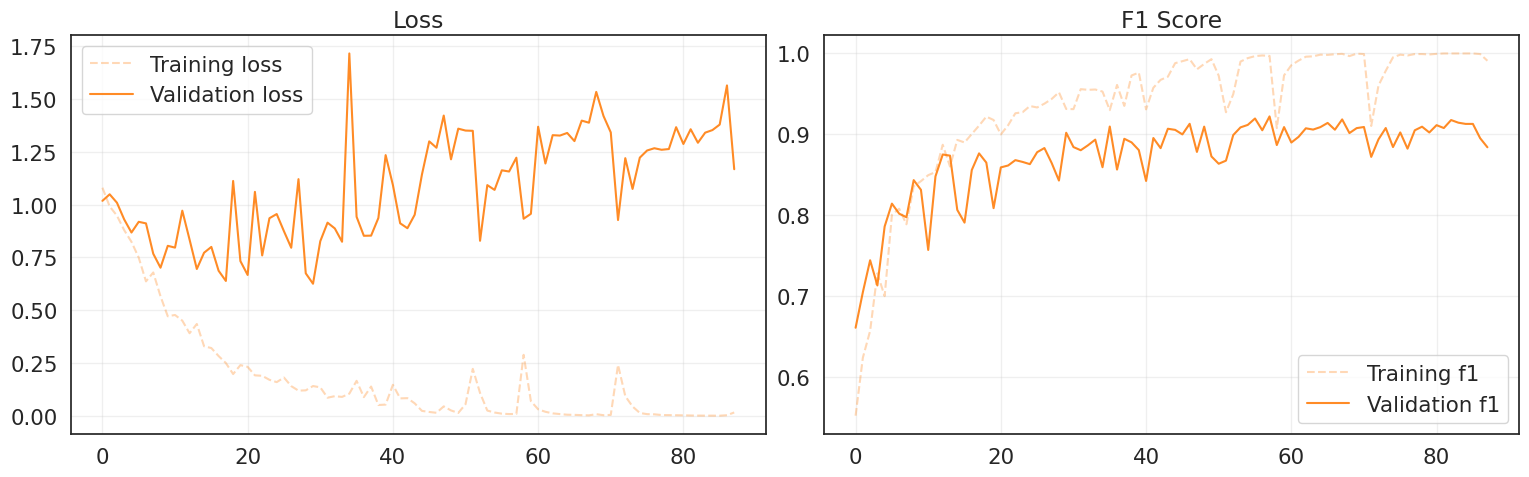

In [57]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9257
Precision over the validation set: 0.9228
Recall over the validation set: 0.9257
F1 score over the validation set: 0.9222


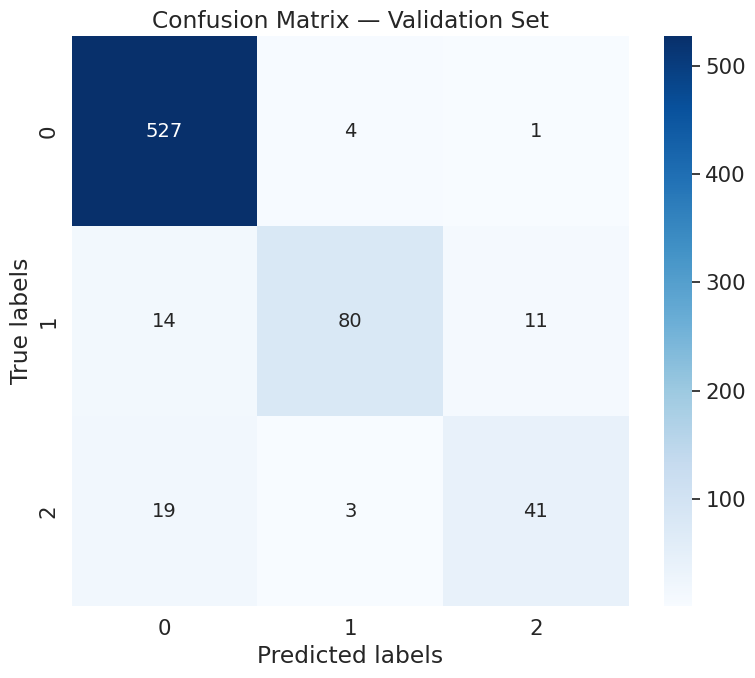

In [58]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [54]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set (Aggregated by Subject)

    rnn_model.eval()
    test_preds = []

    with torch.no_grad():
        # Inferenza batch-by-batch sugli array X_test
        for i in range(0, len(X_test), 256):   # puoi modificare la batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    # Concatena i batch
    test_preds = np.concatenate(test_preds)       # (N_windows, C)

    # --- Generate subj_ids for X_test --- #
    # This is crucial because `subj_ids` previously was for X_test_s (211840 rows)
    # while X_test and y_test are for df_test (12800 rows).
    subj_ids_test = make_subj_ids(df_test, WINDOW_SIZE, STRIDE)

    # --- Aggregazione per pirata (sample_index) ---
    unique_ids = np.unique(subj_ids_test) # Use subj_ids_test here
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = subj_ids_test == sid # Use subj_ids_test here
        probs_sid = test_preds[mask]          # (N_windows_subject, C)
        y_true_sid = y_test[mask][0]          # stessa label per tutte le finestre del soggetto
        probs_agg = np.mean(probs_sid, axis=0)  # usa la media; puoi provare np.median
        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)

    # --- Metriche globali ---
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set: {test_acc:.4f}")
    print(f"Precision over the test set: {test_prec:.4f}")
    print(f"Recall over the test set: {test_rec:.4f}")
    print(f"F1 score over the test set: {test_f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set (Aggregated by Subject)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Test Set Confusion Matrix for BiGRU as N_TEST_USERS is {N_TEST_USERS}")

Skipping Test Set Confusion Matrix for BiGRU as N_TEST_USERS is 0


In [55]:
# @title Generate Submission File for X_test_s

# Ensure the model is in evaluation mode
rnn_model.eval()

# List to store predictions for all windows in X_test_s
test_s_window_preds = []

with torch.no_grad():
    # Iterate through X_test_s in batches for inference
    for i in range(0, len(X_test_s), 256):  # Using a batch size of 256 for inference
        # Create a tensor from the batch of data, move to device
        xb = torch.tensor(X_test_s[i:i+256], dtype=torch.float32, device=device)

        # Perform forward pass to get logits
        logits = rnn_model(xb)

        # Apply softmax to get probabilities and convert to numpy
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store the probabilities for each window
        test_s_window_preds.append(probs)

# Concatenate all batch predictions into a single array
test_s_window_preds = np.concatenate(test_s_window_preds) # Shape: (N_windows, num_classes)

# --- Aggregation per subject (sample_index) ---
# The 'subj_ids' array already generated from df_test_s in an earlier cell (hJfdTVU8MWq9)
# is appropriate here.

# Get unique sample indices from the test submission data
unique_sample_indices = np.unique(subj_ids)

final_predictions = []

for sid in unique_sample_indices:
    # Get the mask for the current sample_index
    mask = subj_ids == sid

    # Select the probabilities for all windows belonging to this sample_index
    probs_for_subject = test_s_window_preds[mask]

    # Aggregate probabilities by taking the mean across all windows for this subject
    # This gives a single probability distribution over classes for the subject
    aggregated_probs = np.mean(probs_for_subject, axis=0)

    # The final prediction is the class with the highest aggregated probability
    predicted_label_index = np.argmax(aggregated_probs)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# Convert to DataFrame
submission_df = pd.DataFrame(final_predictions)

# Map integer labels back to original string labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

# Construct the full path for the submission file in Google Drive
submission_file_path = os.path.join(current_dir.replace('\\', ''), 'submission_gru_bi.csv')

# Select only the required columns and save to CSV in Google Drive
submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_gru_bi.csv' created successfully.
   sample_index  predicted_label_index    label
0             0                      0  no_pain
1             1                      0  no_pain
2             2                      0  no_pain
3             3                      0  no_pain
4             4                      0  no_pain


In [56]:
# Copy TensorBoard logs to accessible location for Colab
!rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir/

# Launch TensorBoard interface
%tensorboard --logdir "/content/"$logs_dir

rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at io.c(519) [generator=3.2.7]
rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at rsync.c(716) [sender=3.2.7]


Launching TensorBoard...

KeyboardInterrupt: 

## **K-Shuffle-Split Cross Validation**

In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 5          # Number of users for validation split
N_TEST_USERS = 5         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 200        # Input window size
STRIDE = 50              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = False    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [ ]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, n_test_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_users: Number of users for validation set
        n_test_users: Number of users for test set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get model architecture parameters
    in_features = 3  # x_axis, y_axis, z_axis
    num_classes = len(df['activity'].unique())

    # Initialise model architecture
    model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique user IDs and shuffle them with split-specific seed
        unique_users = df['user_id'].unique()
        random.seed(seed + split_idx)
        random.shuffle(unique_users)

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users - n_test_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users = unique_users[n_train_users:n_train_users + n_val_users]
        test_users = unique_users[n_train_users + n_val_users:]

        # Split the dataset into training, validation, and test sets based on user IDs
        df_train = df[df['user_id'].isin(train_users)].copy()
        df_val = df[df['user_id'].isin(val_users)].copy()
        df_test = df[df['user_id'].isin(test_users)].copy()

        # Define a mapping of activity names to integer labels
        label_mapping = {
            'Walking': 0,
            'Jogging': 1,
            'Upstairs': 2,
            'Downstairs': 3,
            'Sitting': 4,
            'Standing': 5
        }

        # Map activity names to integers in the training set
        df_train['activity'] = df_train['activity'].map(label_mapping)

        # Map activity names to integers in the validation set
        df_val['activity'] = df_val['activity'].map(label_mapping)

        # Map activity names to integers in the test set
        df_test['activity'] = df_test['activity'].map(label_mapping)

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")
            print(f"  Test set shape: {df_test.shape}")

        # Normalise features using training set statistics
        train_max = df_train[['x_axis', 'y_axis', 'z_axis']].max()
        train_min = df_train[['x_axis', 'y_axis', 'z_axis']].min()

        df_train[['x_axis', 'y_axis', 'z_axis']] = (df_train[['x_axis', 'y_axis', 'z_axis']] - train_min) / (train_max - train_min + 1e-8)
        df_val[['x_axis', 'y_axis', 'z_axis']] = (df_val[['x_axis', 'y_axis', 'z_axis']] - train_min) / (train_max - train_min + 1e-8)
        df_test[['x_axis', 'y_axis', 'z_axis']] = (df_test[['x_axis', 'y_axis', 'z_axis']] - train_min) / (train_max - train_min + 1e-8)

        # Build sequences using the existing build_sequences function
        X_train, y_train = build_sequences(df_train, window=window_size, stride=stride)
        X_val, y_val = build_sequences(df_val, window=window_size, stride=stride)
        X_test, y_test = build_sequences(df_test, window=window_size, stride=stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")
            print(f"  Test sequences shape: {X_test.shape}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
        test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
        test_loader  = make_loader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
    df=df,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="gru_baseline",
    n_val_users=N_VAL_USERS,
    n_test_users=N_TEST_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

In [ ]:
# @title Plot Hitory
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

## **Hyperparameters Tuning**

In [ ]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'window_size': [50, 100, 200, 400],
    'stride': [25, 50],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_users': N_VAL_USERS,
    'n_test_users': N_TEST_USERS,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)

In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# %%time
# --- 1. Combine fixed and best hyperparameters ---
# 'fixed_params' and 'best_config' are loaded from the grid search cell
final_best_params = {**fixed_params, **best_config}

# Generate config string (from grid params only) to find saved model files
best_config_str = "_".join([f"{k}_{v}" for k, v in best_config.items()])

# Initialise lists for metrics
test_accuracies = []
test_precisions = []
test_recall_scores = []
test_f1_scores = []
all_test_targets = [] # For aggregated confusion matrix
all_test_preds = []   # For aggregated confusion matrix

label_mapping = {
    'Walking': 0, 'Jogging': 1, 'Upstairs': 2,
    'Downstairs': 3, 'Sitting': 4, 'Standing': 5
}
scale_columns = ['x_axis', 'y_axis', 'z_axis']

# --- 2. Begin evaluation loop across the K splits ---
# K, SEED, N_VAL_USERS, N_TEST_USERS are defined globally
for split in range(K):
    print(f"Evaluating Split {split+1}/{K} using best config: {best_config_str}")

    # --- 3. Regenerate the exact data split for this fold ---
    # This logic must be identical to k_shuffle_split_cross_validation_round_rnn
    unique_users = df['user_id'].unique()
    random.seed(SEED + split) # Use the same CV seed
    random.shuffle(unique_users)

    n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS
    train_users = unique_users[:n_train_users]
    val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]
    test_users = unique_users[n_train_users + N_VAL_USERS:]

    df_train = df[df['user_id'].isin(train_users)].copy()
    df_test = df[df['user_id'].isin(test_users)].copy()

    # --- 4. Preprocess the data ---
    df_train['activity'] = df_train['activity'].map(label_mapping)
    df_test['activity'] = df_test['activity'].map(label_mapping)

    # Normalise features (fit on THIS split's training data)
    mins = df_train[scale_columns].min()
    maxs = df_train[scale_columns].max()

    for column in scale_columns:
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column] + 1e-8)

    # --- 5. Build test sequences ---
    # Use the best window/stride from final_best_params
    X_test, y_test = build_sequences(
        df_test,
        window=final_best_params['window_size'],
        stride=final_best_params['stride']
    )

    # --- 6. Create the Test DataLoader ---
    test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    test_loader  = make_loader(
        test_ds,
        batch_size=final_best_params['batch_size'],
        shuffle=False,
        drop_last=False
    )

    # Handle empty test sets from user splits
    if len(test_ds) == 0:
        print(f"  WARNING: Test set for split {split+1} is empty. Skipping.")
        continue

    # --- 7. Initialise the Model ---
    # Use the best architecture parameters from the grid search
    model = RecurrentClassifier(
        input_size=X_test.shape[2], # num_features (3)
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        num_classes=len(label_mapping), # num_classes (6)
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

    # --- 8. Load the model weights for this specific split and config ---
    model_path = f"models/{best_config_str}/split_{split}_model.pt"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  ERROR: Model file not found at {model_path}")
        print(f"  Skipping split {split+1}.")
        continue

    model.eval() # Set model to evaluation mode

    # --- 9. Run predictions on the test set ---
    split_test_preds, split_test_targets = [], []
    with torch.no_grad(): # Disable gradient computation for inference
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            split_test_preds.append(preds)
            split_test_targets.append(yb.numpy())

    split_test_preds = np.concatenate(split_test_preds)
    split_test_targets = np.concatenate(split_test_targets)

    # --- 10. Calculate and store metrics for this split ---
    split_test_acc = accuracy_score(split_test_targets, split_test_preds)
    split_test_prec = precision_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_rec = recall_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_f1 = f1_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)

    print(f"  Test F1 Score for Split {split+1}: {split_test_f1:.4f}")

    test_accuracies.append(split_test_acc)
    test_precisions.append(split_test_prec)
    test_recall_scores.append(split_test_rec)
    test_f1_scores.append(split_test_f1)

    all_test_targets.extend(split_test_targets)
    all_test_preds.extend(split_test_preds)


# --- 11. After the loop: Print mean metrics and plot confusion matrix ---
print("\nAverage metrics across all splits on the test set:")
print(f"Mean Accuracy: {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
print(f"Mean Precision: {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Mean Recall: {np.mean(test_recall_scores):.4f} ± {np.std(test_recall_scores):.4f}")
print(f"Mean F1 score: {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")


# Generate confusion matrix for the concatenated test sets
cm = confusion_matrix(all_test_targets, all_test_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix — Test Sets Across Splits')
plt.tight_layout()
plt.show()

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

##### Connect with us:
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="14"> **LinkedIn:**  [AIRLab Polimi](https://www.linkedin.com/company/airlab-polimi/)
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="14"> **Instagram:** [airlab_polimi](https://www.instagram.com/airlab_polimi/)

##### Contributors:
- **Eugenio Lomurno**: eugenio.lomurno@polimi.it
- **Alberto Archetti**: alberto.archetti@polimi.it
- **Roberto Basla**: roberto.basla@polimi.it
- **Carlo Sgaravatti**: carlo.sgaravatti@polimi.it

```
   Copyright 2025 Eugenio Lomurno, Alberto Archetti, Roberto Basla, Carlo Sgaravatti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```

# Task
Apply class weights to the `nn.CrossEntropyLoss` criterion using the pre-calculated `weights` tensor, then retrain the Bidirectional GRU (BiGRU) model with this weighted loss function. After retraining, plot the training history (loss and F1 score) and generate a confusion matrix for the retrained BiGRU model on the validation set to evaluate the impact of class weighting on its performance, particularly concerning 'high_pain' predictions.

## Apply Class Weights to Loss Function

### Subtask:
Modify the `criterion` (nn.CrossEntropyLoss) to incorporate the previously calculated class weights (`weights`) to address the class imbalance, making the model more sensitive to minority classes like 'high_pain'. This will involve moving the `weights` tensor to the correct device and passing it to the `CrossEntropyLoss` constructor.


**Reasoning**:
The subtask requires modifying the `criterion` to incorporate class weights. This involves converting the NumPy `weights` array to a PyTorch tensor, moving it to the correct device, and then initializing `nn.CrossEntropyLoss` with this weighted tensor.



## Apply Class Weights to Loss Function

### Subtask:
Modify the `criterion` (nn.CrossEntropyLoss) to incorporate the previously calculated class weights (`weights`) to address the class imbalance, making the model more sensitive to minority classes like 'high_pain'. This will involve moving the `weights` tensor to the correct device and passing it to the `CrossEntropyLoss` constructor.


**Reasoning**:
The subtask requires modifying the `criterion` to incorporate class weights. This involves converting the NumPy `weights` array to a PyTorch tensor, moving it to the correct device, and then initializing `nn.CrossEntropyLoss` with this weighted tensor.



## Retrain Bidirectional GRU (BiGRU) Model with Weighted Loss

Now that the `criterion` has been updated to include class weights, we will retrain the BiGRU model using this weighted loss function. After training, we will visualize its performance through the training history and a confusion matrix on the validation set.

## Retrain Bidirectional GRU (BiGRU) Model with Weighted Loss

Now that the `criterion` has been updated to include class weights, we will retrain the BiGRU model using this weighted loss function. After training, we will visualize its performance through the training history and a confusion matrix on the validation set.

**Reasoning**:
The subtask requires retraining the BiGRU model with the new weighted loss function. This involves redefining the model and then calling the `fit` function with the updated `criterion`.



## Modifica criterio con pesi di classe

### Subtask:
Initialize nn.CrossEntropyLoss with pre-calculated class weights to address class imbalance.


**Reasoning**:
The user explicitly asked to modify the `criterion` in cell `HxtAqB60mcAd` to include class weights. The provided instruction gives the exact code snippet to achieve this, by converting the `weights` numpy array to a PyTorch tensor and moving it to the `device` before initializing `nn.CrossEntropyLoss`.



## Modifica criterio con pesi di classe

### Subtask:
Modificherò la cella HxtAqB60mcAd per inizializzare nn.CrossEntropyLoss con i pesi di classe pre-calcolati, sovrascrivendo la definizione esistente del criterio.


**Reasoning**:
The subtask explicitly asks to modify cell HxtAqB60mcAd by replacing the existing `criterion` definition with one that includes pre-calculated class weights. The provided Python code snippet directly achieves this.

